# CS677 Project - Fall 2021

## Detection of Face Masks

### Rohan J Aditya (U17792248)

### Import the necessary packages

In [1]:
import os
import glob
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import warnings
warnings.filterwarnings('ignore')

### Versions of packages used

* NumPy: 1.21.2
* Pandas: 1.3.4
* OpenCV: 4.5.1
* TensorFlow GPU: 2.5.0
* Seaborn: 0.11.0
* Matplotlib: 3.5.0

An environment (.yml) file is also included in the submission to recreate the Anaconda environment that was used.

### Data Set Source
https://www.kaggle.com/andrewmvd/face-mask-detection

### Folder paths

In [2]:
path_annotations = "annotations"
path_images = "images"
path_cropped = "cropped_images"

### Parse .xml files
This section deals with the parsing of xml files containing information about the data set.

In [3]:
if "annotations.csv" not in os.listdir():
    
    data = {
            'filename': [], 
            'name': [], 
            'height': [], 
            'width': [], 
            'xmin': [], 
            'ymin': [], 
            'xmax': [], 
            'ymax': []
           }
    
    for annotation in glob.glob(path_annotations + "/*.xml"):

        tree = ET.parse(annotation)
        for element in tree.iter():
            
            # Height and width of the source image of each face
            if 'size' in element.tag:
                for attribute in list(element):
                    if 'width' in attribute.tag:
                        width = int(round(float(attribute.text)))
                    if 'height' in attribute.tag:
                        height = int(round(float(attribute.text)))

            if 'object' in element.tag:
                for attribute in list(element):
                    if 'name' in attribute.tag:
                        name = attribute.text
                        data['name'] += [name]
                        data['width'] += [width]
                        data['height'] += [height]
                        data['filename'] += [annotation.split('\\')[-1][:-4]]
                    
                    # Bounding box coordinates of each face in the images
                    if 'bndbox' in attribute.tag:
                        for dimension in list(attribute):
                            if 'xmin' in dimension.tag:
                                xmin = int(round(float(dimension.text)))
                                data['xmin'] += [xmin]
                            if 'ymin' in dimension.tag:
                                ymin = int(round(float(dimension.text)))
                                data['ymin'] += [ymin]
                            if 'xmax' in dimension.tag:
                                xmax = int(round(float(dimension.text)))
                                data['xmax'] += [xmax]
                            if 'ymax' in dimension.tag:
                                ymax = int(round(float(dimension.text)))
                                data['ymax'] += [ymax]

    data = pd.DataFrame(data)
    # Annotation file name
    data['annotation'] = path_annotations + '/' + data.filename + '.xml'
    # Source image file name
    data['image_name'] = path_images + '/' + data.filename + '.png'
    
    # Fixing a grammar mistake
    data.loc[data.name=='mask_weared_incorrect', 'name'] = 'incorrectly_worn_mask'

    # File name of images with the cropped faces
    for i in range(len(data)):
        data.loc[i, 'cropped_image_name'] = data.loc[i, 'image_name'][7:-4] + '_' + str(i) + '.png'

    data = data.sort_values('cropped_image_name').reset_index(drop=True)
    data.to_csv("annotations.csv", index=False)
    
else:
    data = pd.read_csv("annotations.csv")

In [4]:
data.head()

,filename,name,height,width,xmin,ymin,xmax,ymax,annotation,image_name,cropped_image_name
0,maksssksksss0,without_mask,366,512,79,105,109,142,annotations/maksssksksss0.xml,images/maksssksksss0.png,maksssksksss0_0.png
1,maksssksksss0,with_mask,366,512,185,100,226,144,annotations/maksssksksss0.xml,images/maksssksksss0.png,maksssksksss0_1.png
2,maksssksksss0,without_mask,366,512,325,90,360,141,annotations/maksssksksss0.xml,images/maksssksksss0.png,maksssksksss0_2.png
3,maksssksksss100,with_mask,226,400,189,30,245,88,annotations/maksssksksss100.xml,images/maksssksksss100.png,maksssksksss100_13.png
4,maksssksksss100,with_mask,226,400,387,54,400,75,annotations/maksssksksss100.xml,images/maksssksksss100.png,maksssksksss100_14.png


### Data set details

The source images contain one or more faces. Each row of the dataframe contains information about each face.

* **filename**: File name of the source image to which the face belongs
* **name**: One of the three classes - *with mask*, *without mask*, or *incorrectly worn mask*
* **height**: Height of the souce image to which the face belongs
* **width**: Width of the souce image to which the face belongs
* **xmin**: First x coordinate of the bounding box of the face in the source image
* **ymin**: Second y coordinate of the bounding box of the face in the source image
* **xmax**: First x coordinate of the bounding box of the face in the source image
* **ymax**: Second y coordinate of the bounding box of the face in the source image
* **annotation**: Path and file name of the annotation xml of the source image
* **image_name**:Path and file name of the source image

## Save cropped images to the directory

In [5]:
def save_cropped_images():
    
    if not os.path.isdir(path_cropped):
        os.mkdir(path_cropped)
        
    for i in range(len(data)):
    
        image = cv2.imread(data.loc[i, 'image_name'])

        x1 = data.loc[i, 'xmin']
        y1 = data.loc[i, 'ymin']
        x2 = data.loc[i, 'xmax']
        y2 = data.loc[i, 'ymax']

        cropped_image = image[y1:y2+1, x1:x2+1]

        cv2.imwrite(path_cropped + "/" + data.loc[i, 'cropped_image_name'], cropped_image)
        

if not os.path.isdir(path_cropped) or len(os.listdir(path_cropped)) != len(data):
            
    save_cropped_images()

## Read cropped images from the directory

In [6]:
def read_cropped_images():
    
    x = []
    for fname in os.listdir(path_cropped):
        x.append( cv2.cvtColor(cv2.imread(path_cropped + "/" + fname), cv2.COLOR_BGR2RGB) )
        
    return x

## One-Hot encode the labels

In [7]:
def one_hot_encode(labels):
    return np.c_[(classes[0] == labels).astype(int), (classes[1] == labels).astype(int), (classes[2] == labels).astype(int)]

## Decode the encoded labels

In [8]:
def label_decoder(labels):
    return classes[np.argmax(labels, axis=1)]

## Images and Labels

In [9]:
classes = np.unique(data.name.values)

In [10]:
X = read_cropped_images()

In [11]:
Y = one_hot_encode(data.name.values)

In [12]:
heights = []
widths = []

for x in X:
    heights.append(x.shape[0])
    widths.append(x.shape[1])

data['cropped_height'] = np.array(heights)
data['cropped_width'] = np.array(widths)
data['cropped_aspect_ratio'] = data.cropped_height.values / data.cropped_width.values

## Exploratory Data Analysis

### 1. Distribution of Labels

In [13]:
cols = ['gold', 'tab:green', 'tab:red']

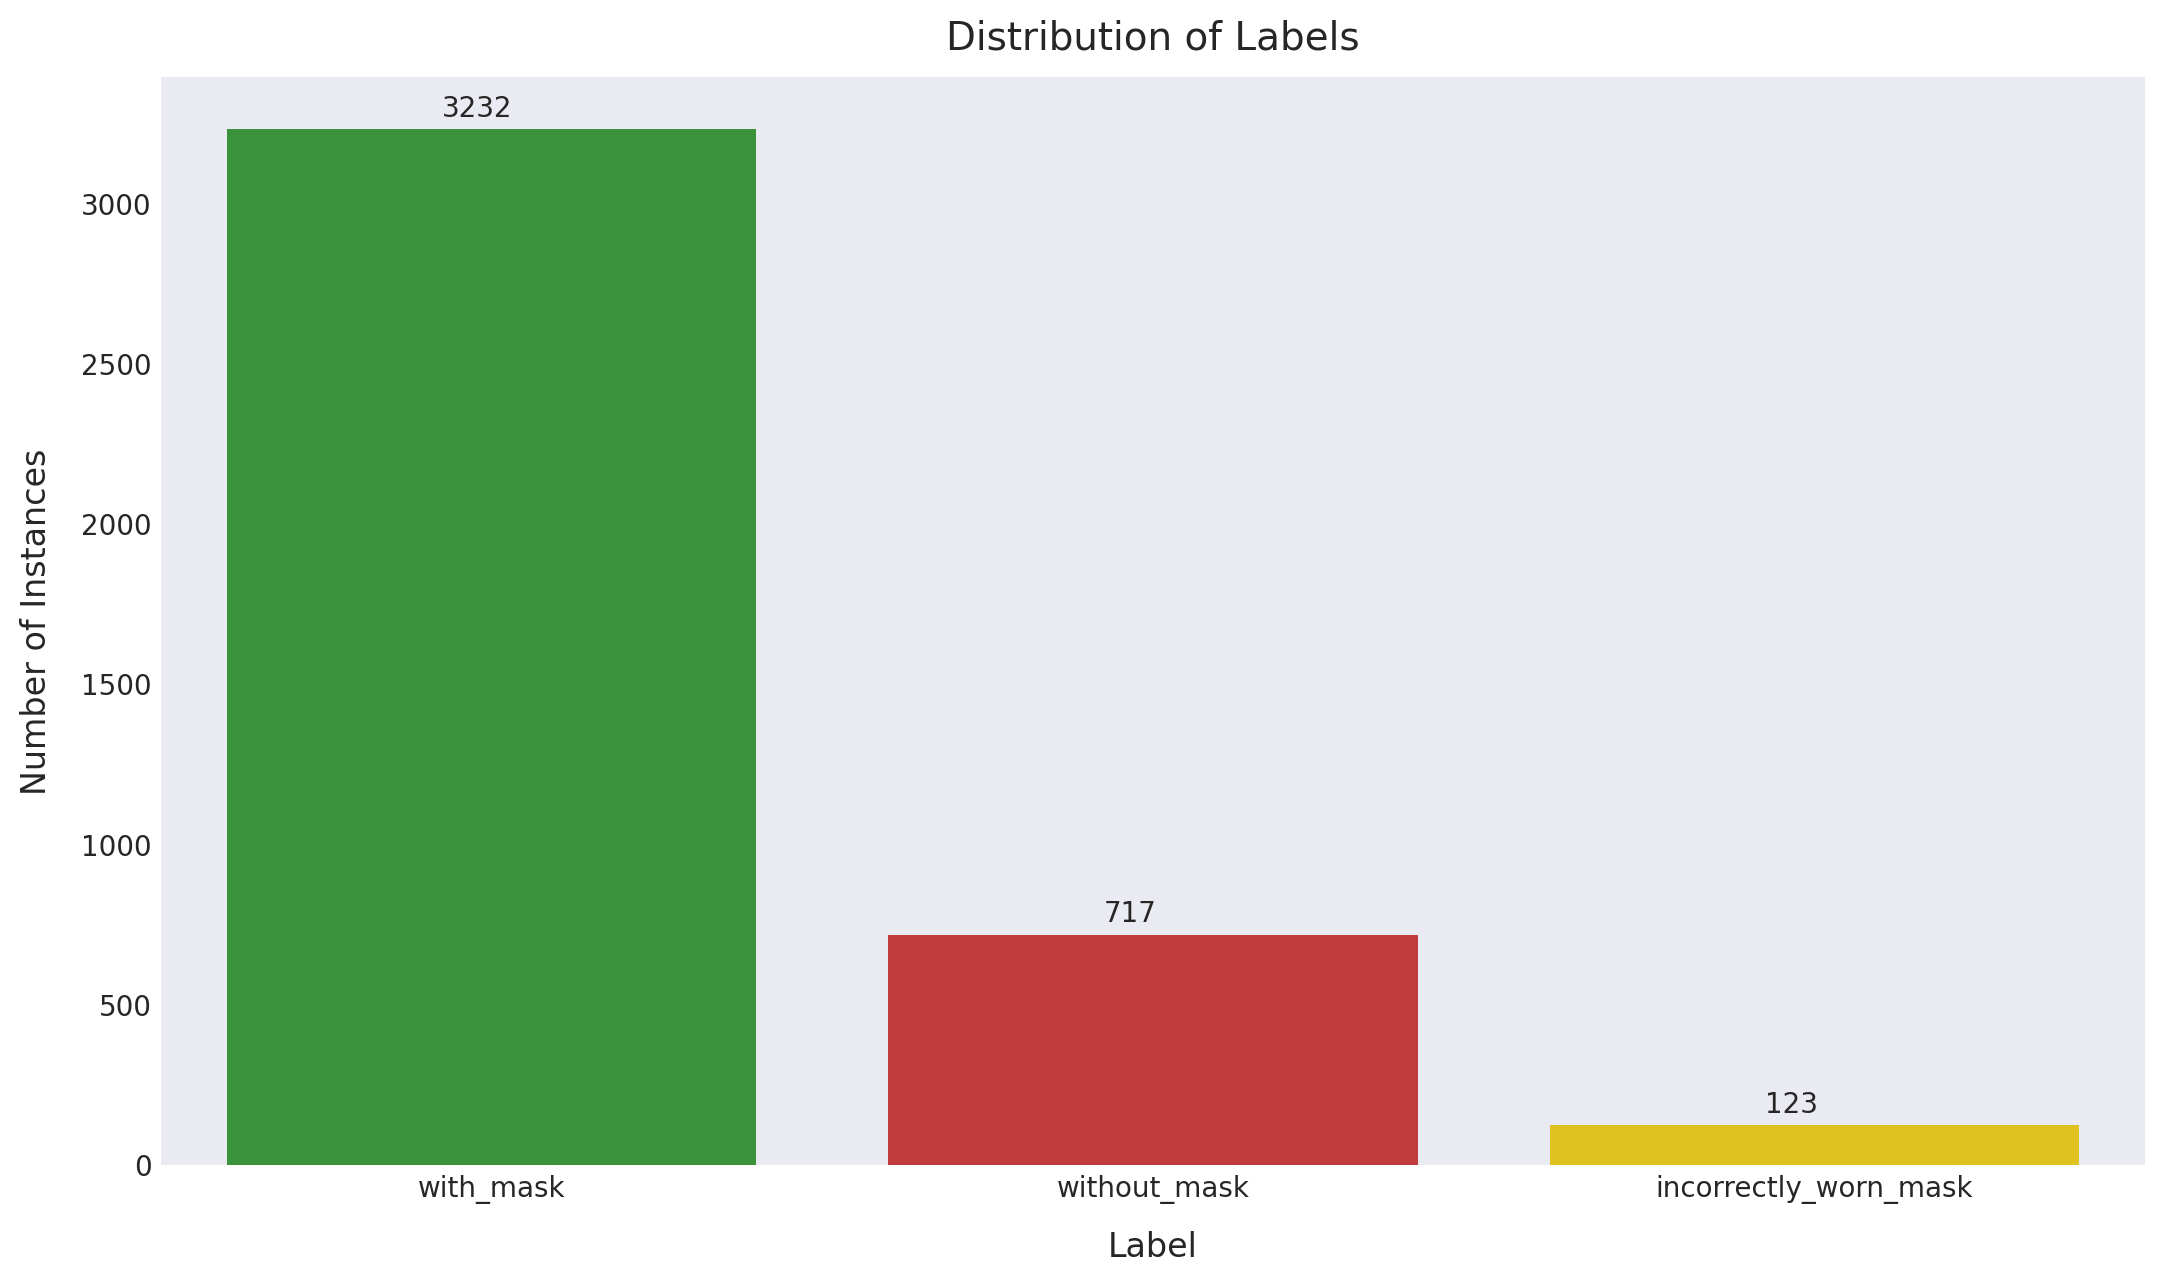

In [14]:
label_counts = pd.DataFrame(data.name.value_counts()).reset_index().rename(columns={'index':'Class','name':'Count'})

with plt.style.context('seaborn-dark'):
    fig, ax = plt.subplots(1, 1, figsize=(12.8,7.2), dpi=200)
    barplot = sns.barplot(data = label_counts, x='Class', y='Count',
                         palette=np.array(cols)[[1,2,0]], ax=ax)
    ax.set_title('Distribution of Labels', fontsize=14, pad=10)
    ax.set_xlabel('Label', fontsize=12, labelpad=10)
    ax.set_ylabel('Number of Instances', fontsize=12, labelpad=10)

    for bar in barplot.patches:
        width = bar.get_width()
        height = bar.get_height()
        ax.text(x=bar.get_x()+width/2-0.075, y=height+40, s=int(height))

### 2. Distribution of the Width of the Cropped Images

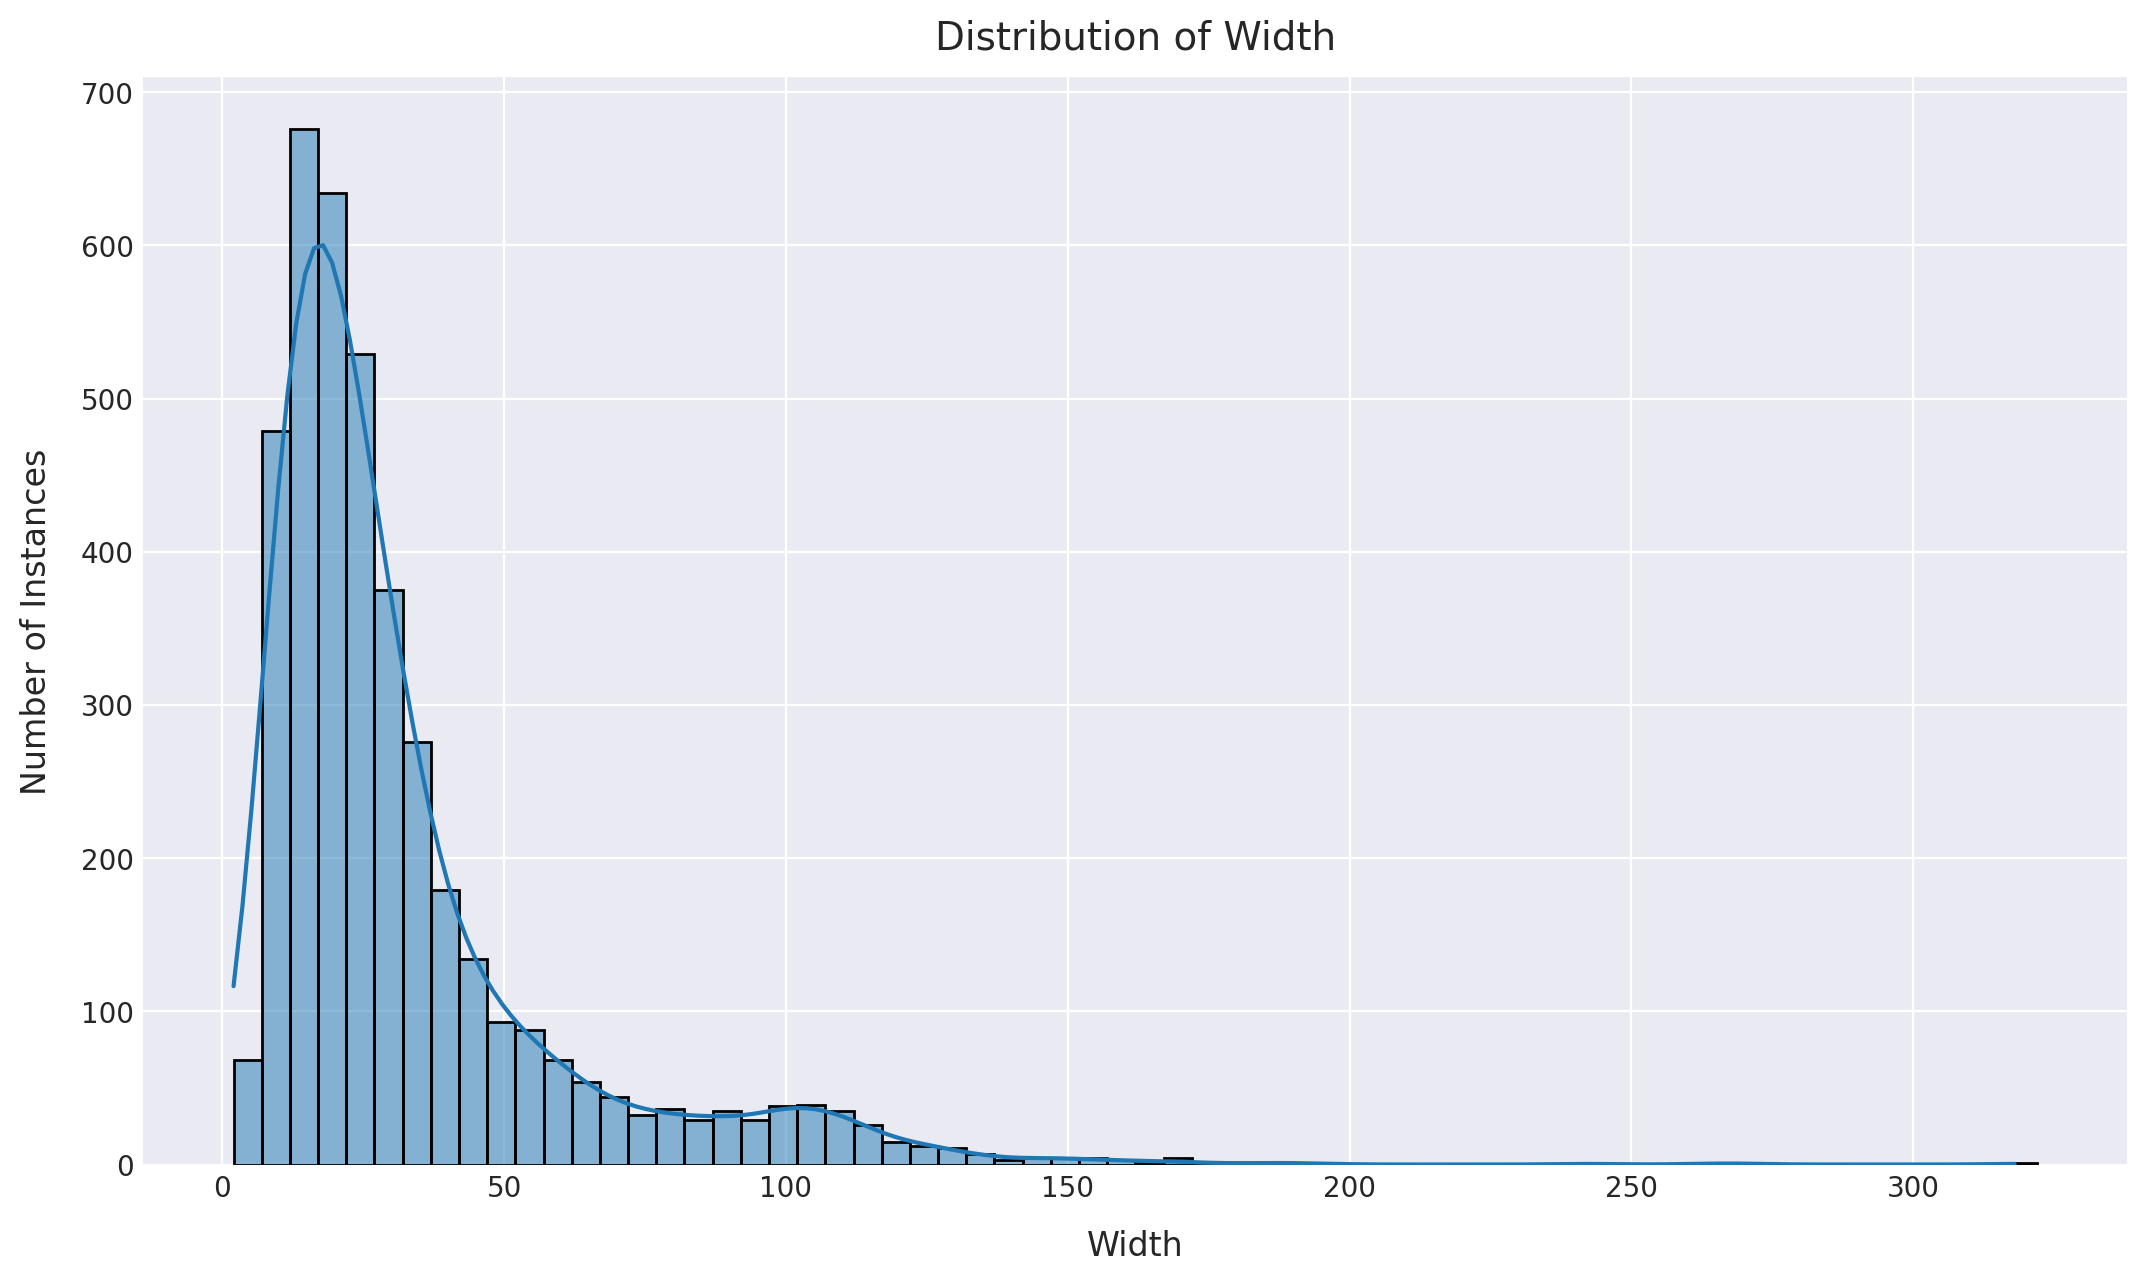

In [15]:
with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(1,1, figsize=(12.8,7.2), dpi=200)
    sns.histplot(data=data, x='cropped_width', kde=True, ax=ax, binwidth=5)
    ax.set_title("Distribution of Width", fontsize=14, pad=10);
    ax.set_xlabel("Width", fontsize=12, labelpad=10);
    ax.set_ylabel("Number of Instances", fontsize=12, labelpad=10);

### 3. Distribution of the Height of the Cropped Images

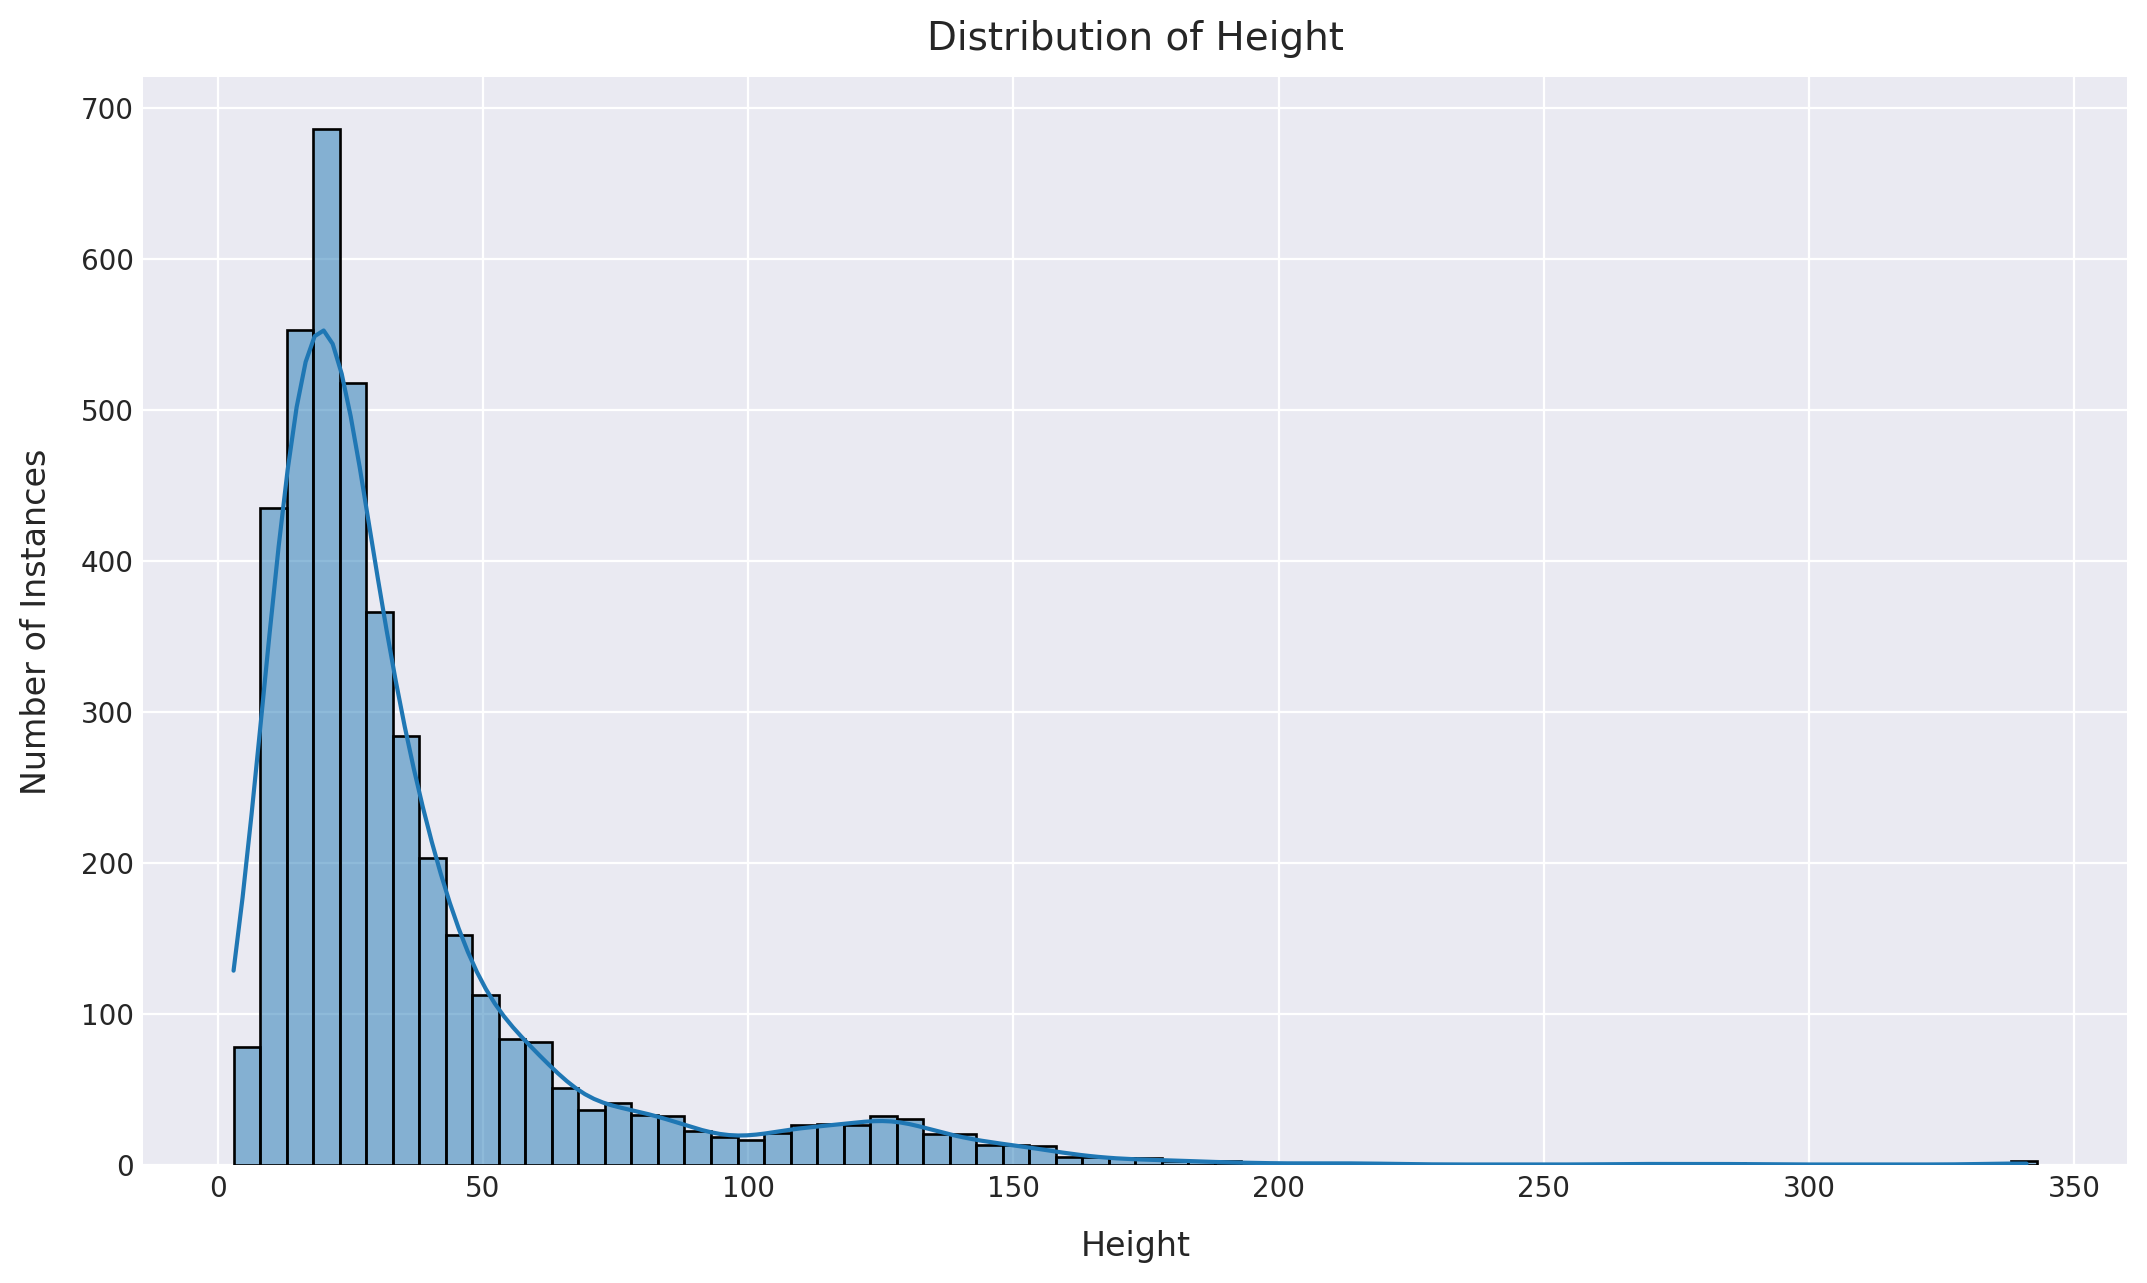

In [16]:
with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(1,1, figsize=(12.8,7.2), dpi=200)
    sns.histplot(data=data, x='cropped_height', kde=True, ax=ax, binwidth=5)
    ax.set_title("Distribution of Height", fontsize=14, pad=10);
    ax.set_xlabel("Height", fontsize=12, labelpad=10);
    ax.set_ylabel("Number of Instances", fontsize=12, labelpad=10);

### 4. Distribution of the Width of the Cropped Images for Each Class

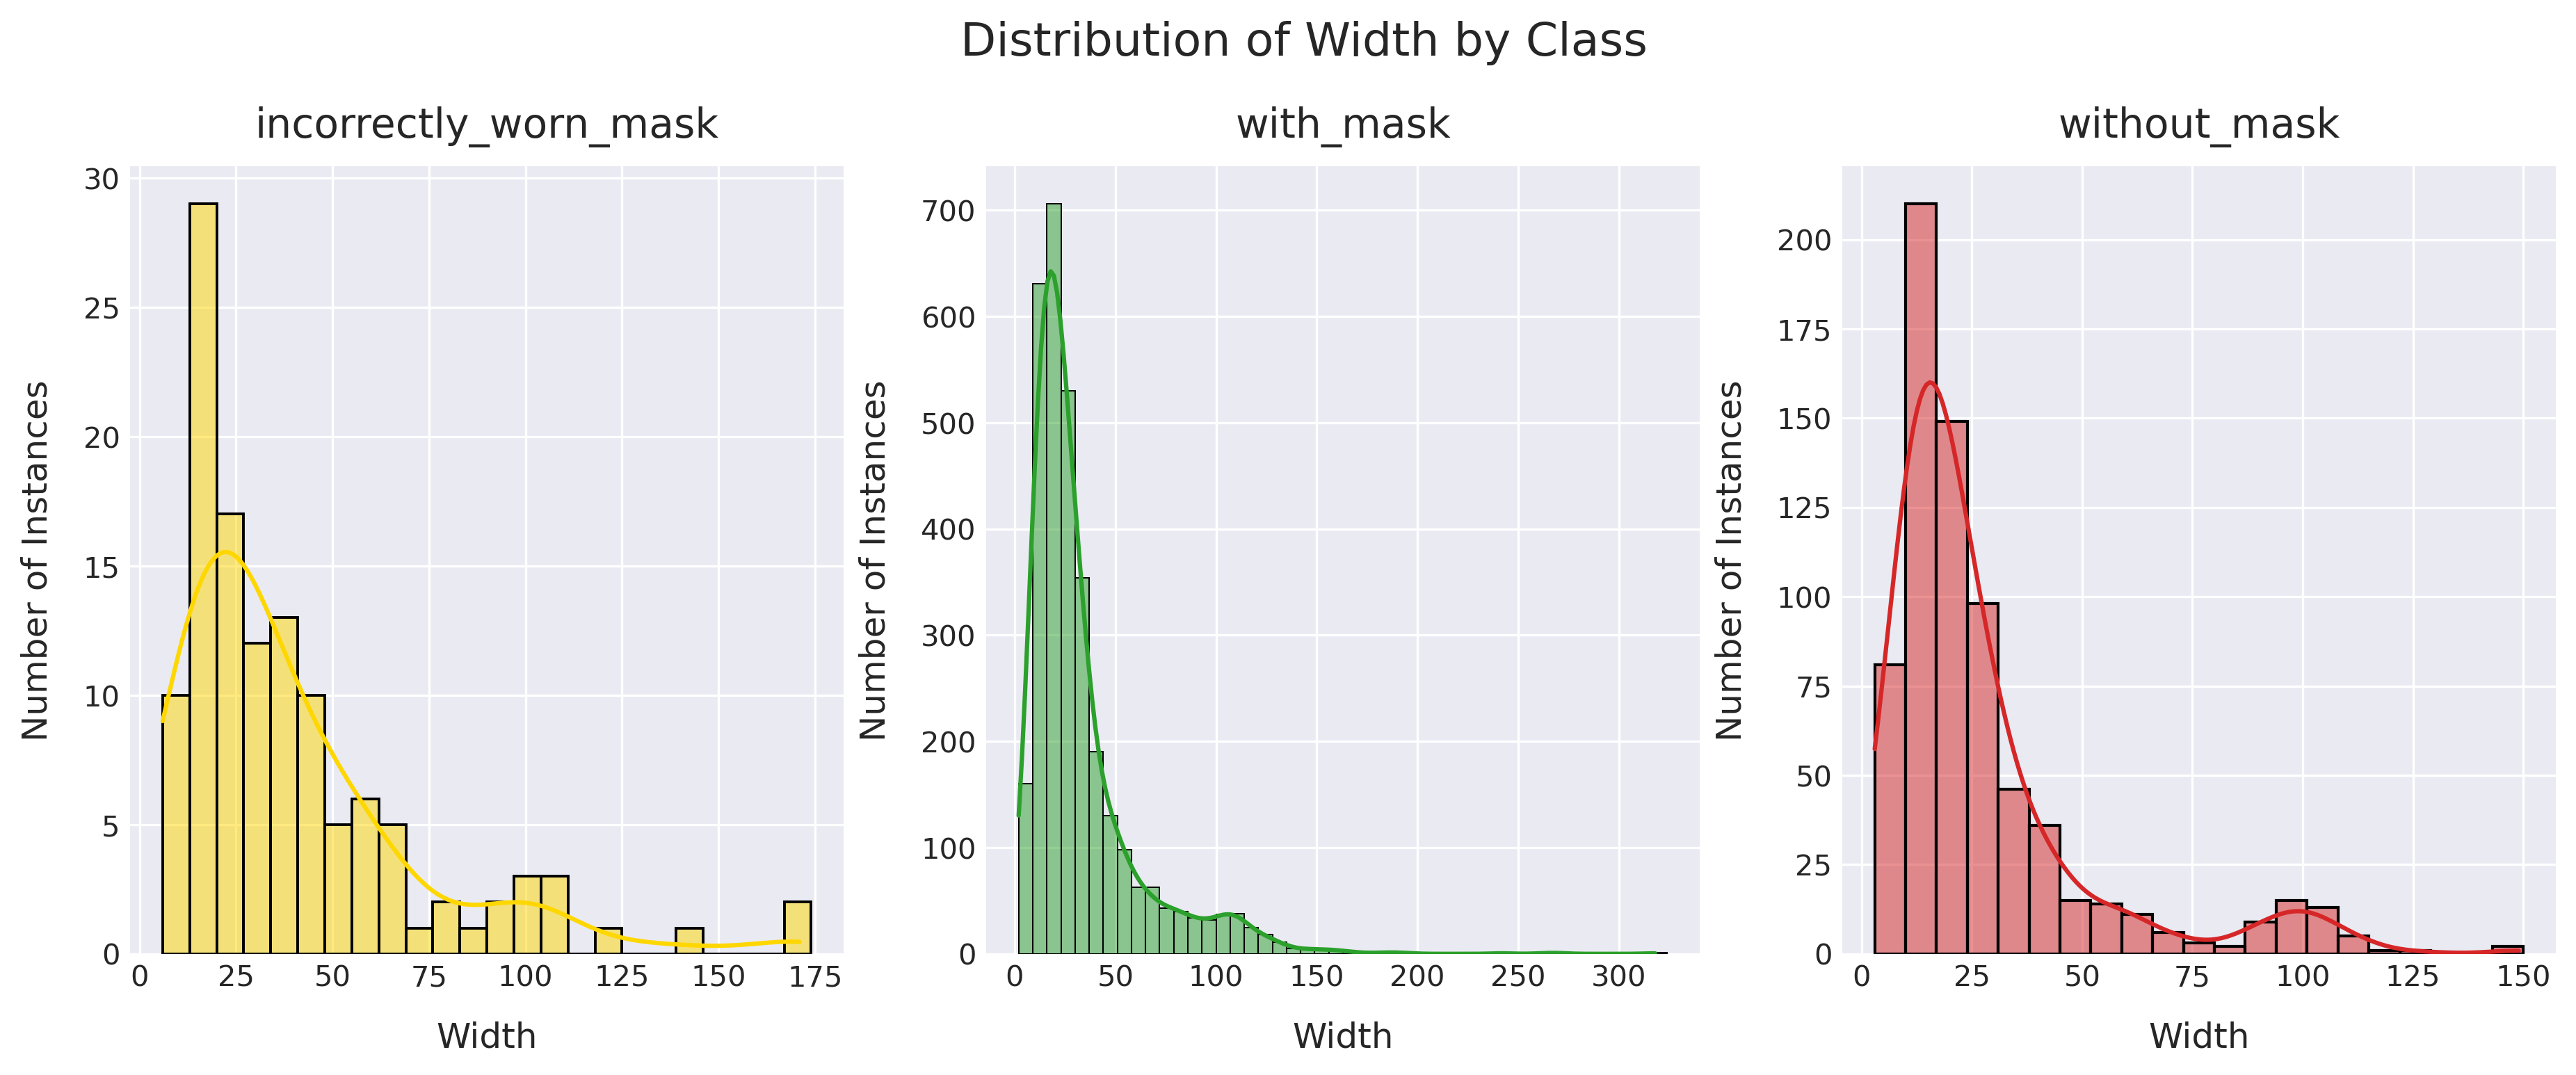

In [17]:
with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(1,3, figsize=(15,5), dpi=300, sharey=False)
    
    for i in range(len(classes)):
        sns.histplot(data.loc[data.name==classes[i]], x='cropped_width', kde=True, ax=ax[i], color=cols[i], binwidth=7)
        ax[i].set_xlabel("Width", fontsize=12, labelpad=10);
        ax[i].set_ylabel("Number of Instances", fontsize=12, labelpad=10);
        ax[i].set_title(classes[i], fontsize=14, pad=10);
        
    fig.suptitle('Distribution of Width by Class', y=1.02, fontsize=16)

### 5. Distribution of Height of the Cropped Images for Each Class

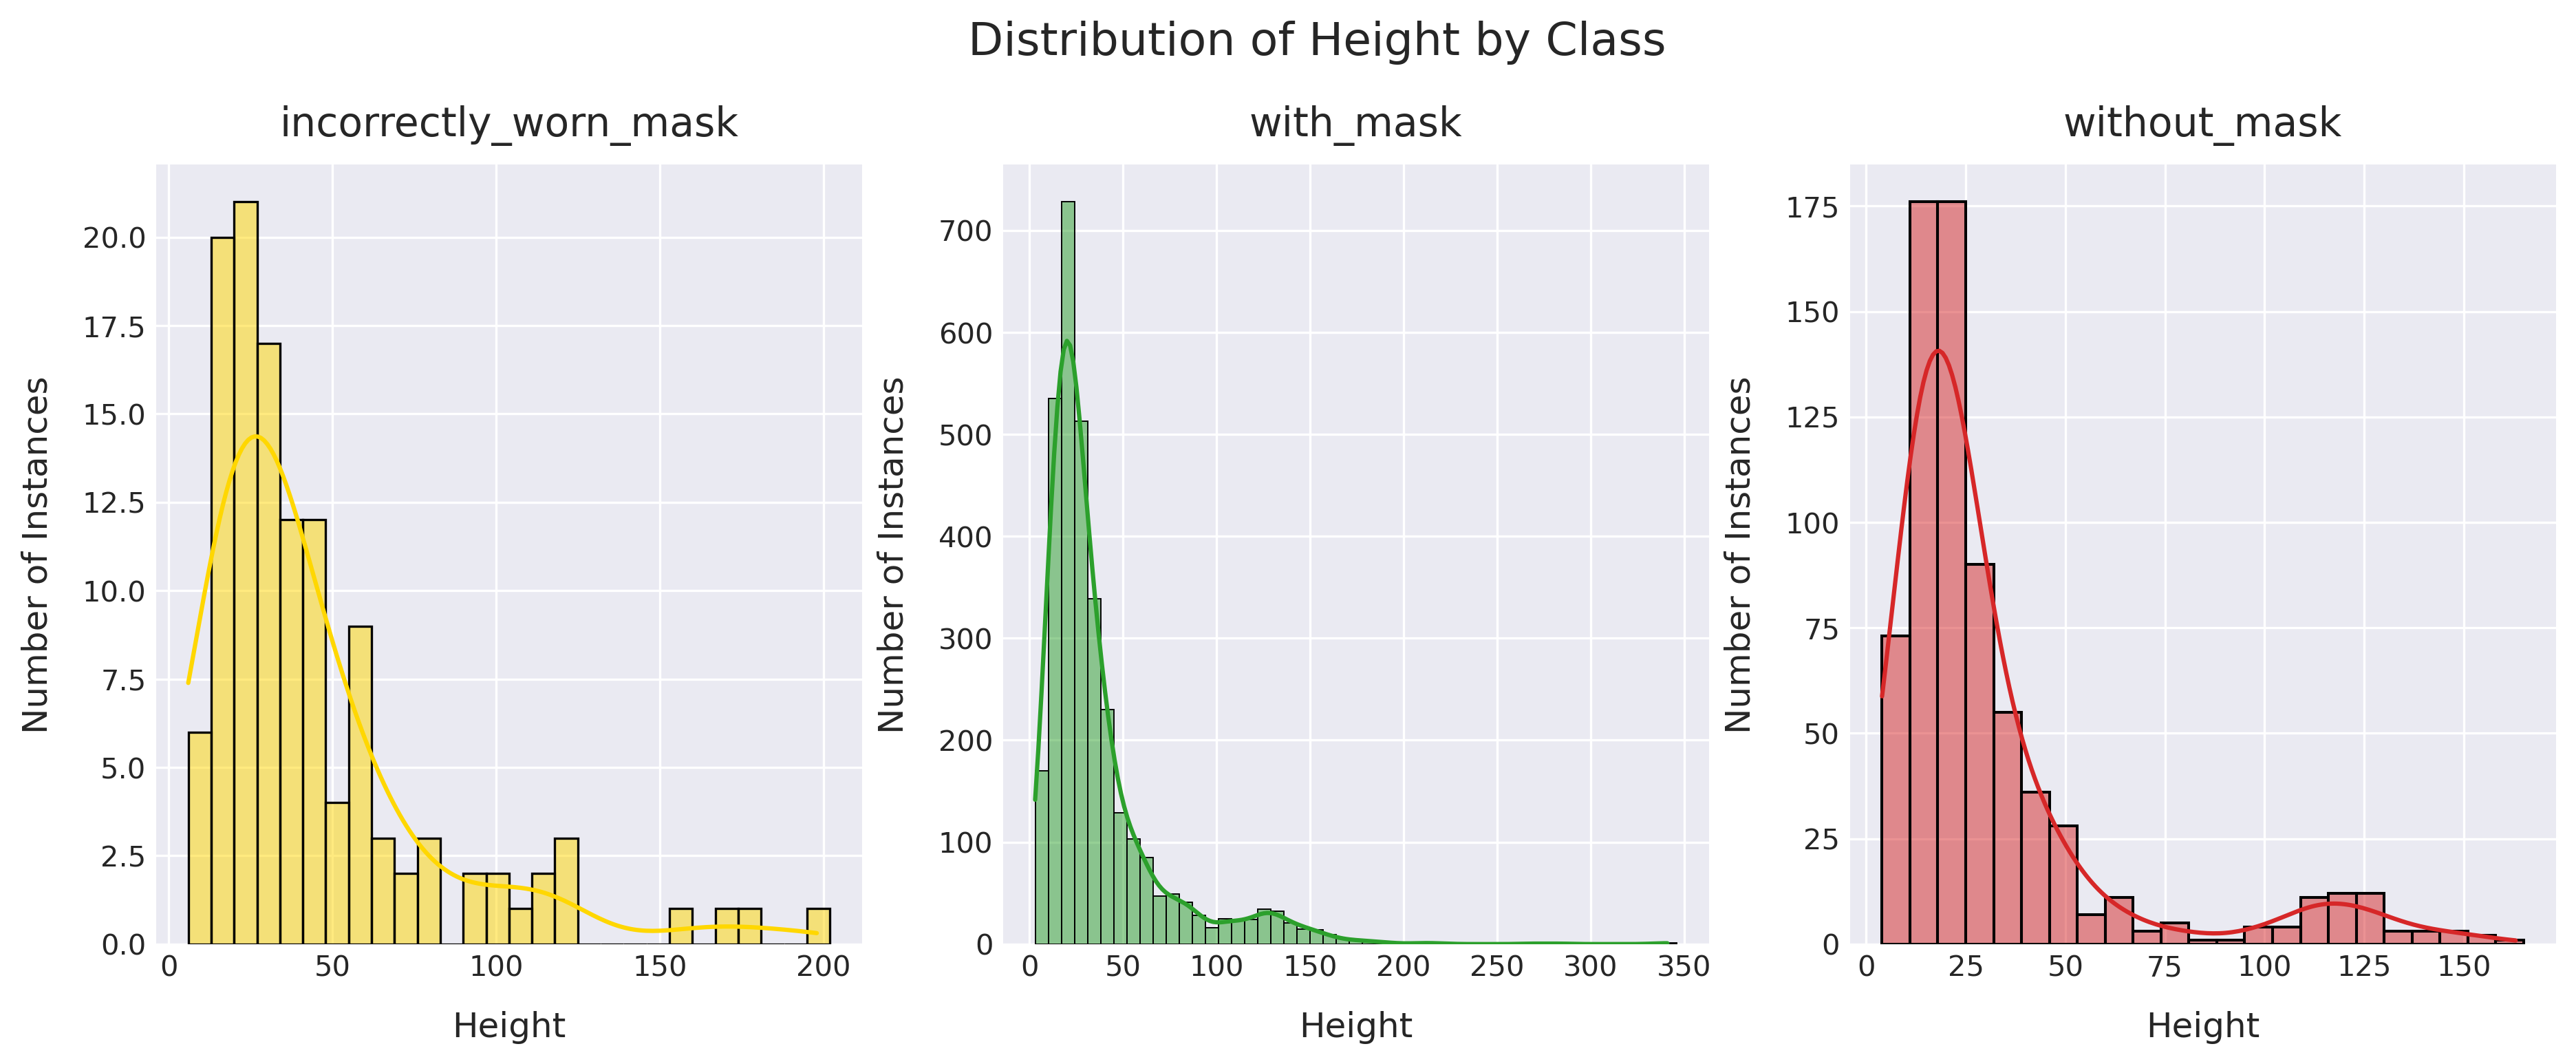

In [18]:
with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(1,3, figsize=(15,5), dpi=300, sharey=False)
    
    for i in range(len(classes)):
        sns.histplot(data.loc[data.name==classes[i]], x='cropped_height', kde=True, ax=ax[i], color=cols[i], binwidth=7)
        ax[i].set_xlabel("Height", fontsize=12, labelpad=10);
        ax[i].set_ylabel("Number of Instances", fontsize=12, labelpad=10);
        ax[i].set_title(classes[i], fontsize=14, pad=10);
        
    fig.suptitle('Distribution of Height by Class', y=1.02, fontsize=16)

### 6. Distribution of Aspect Ratio of the Cropped Images

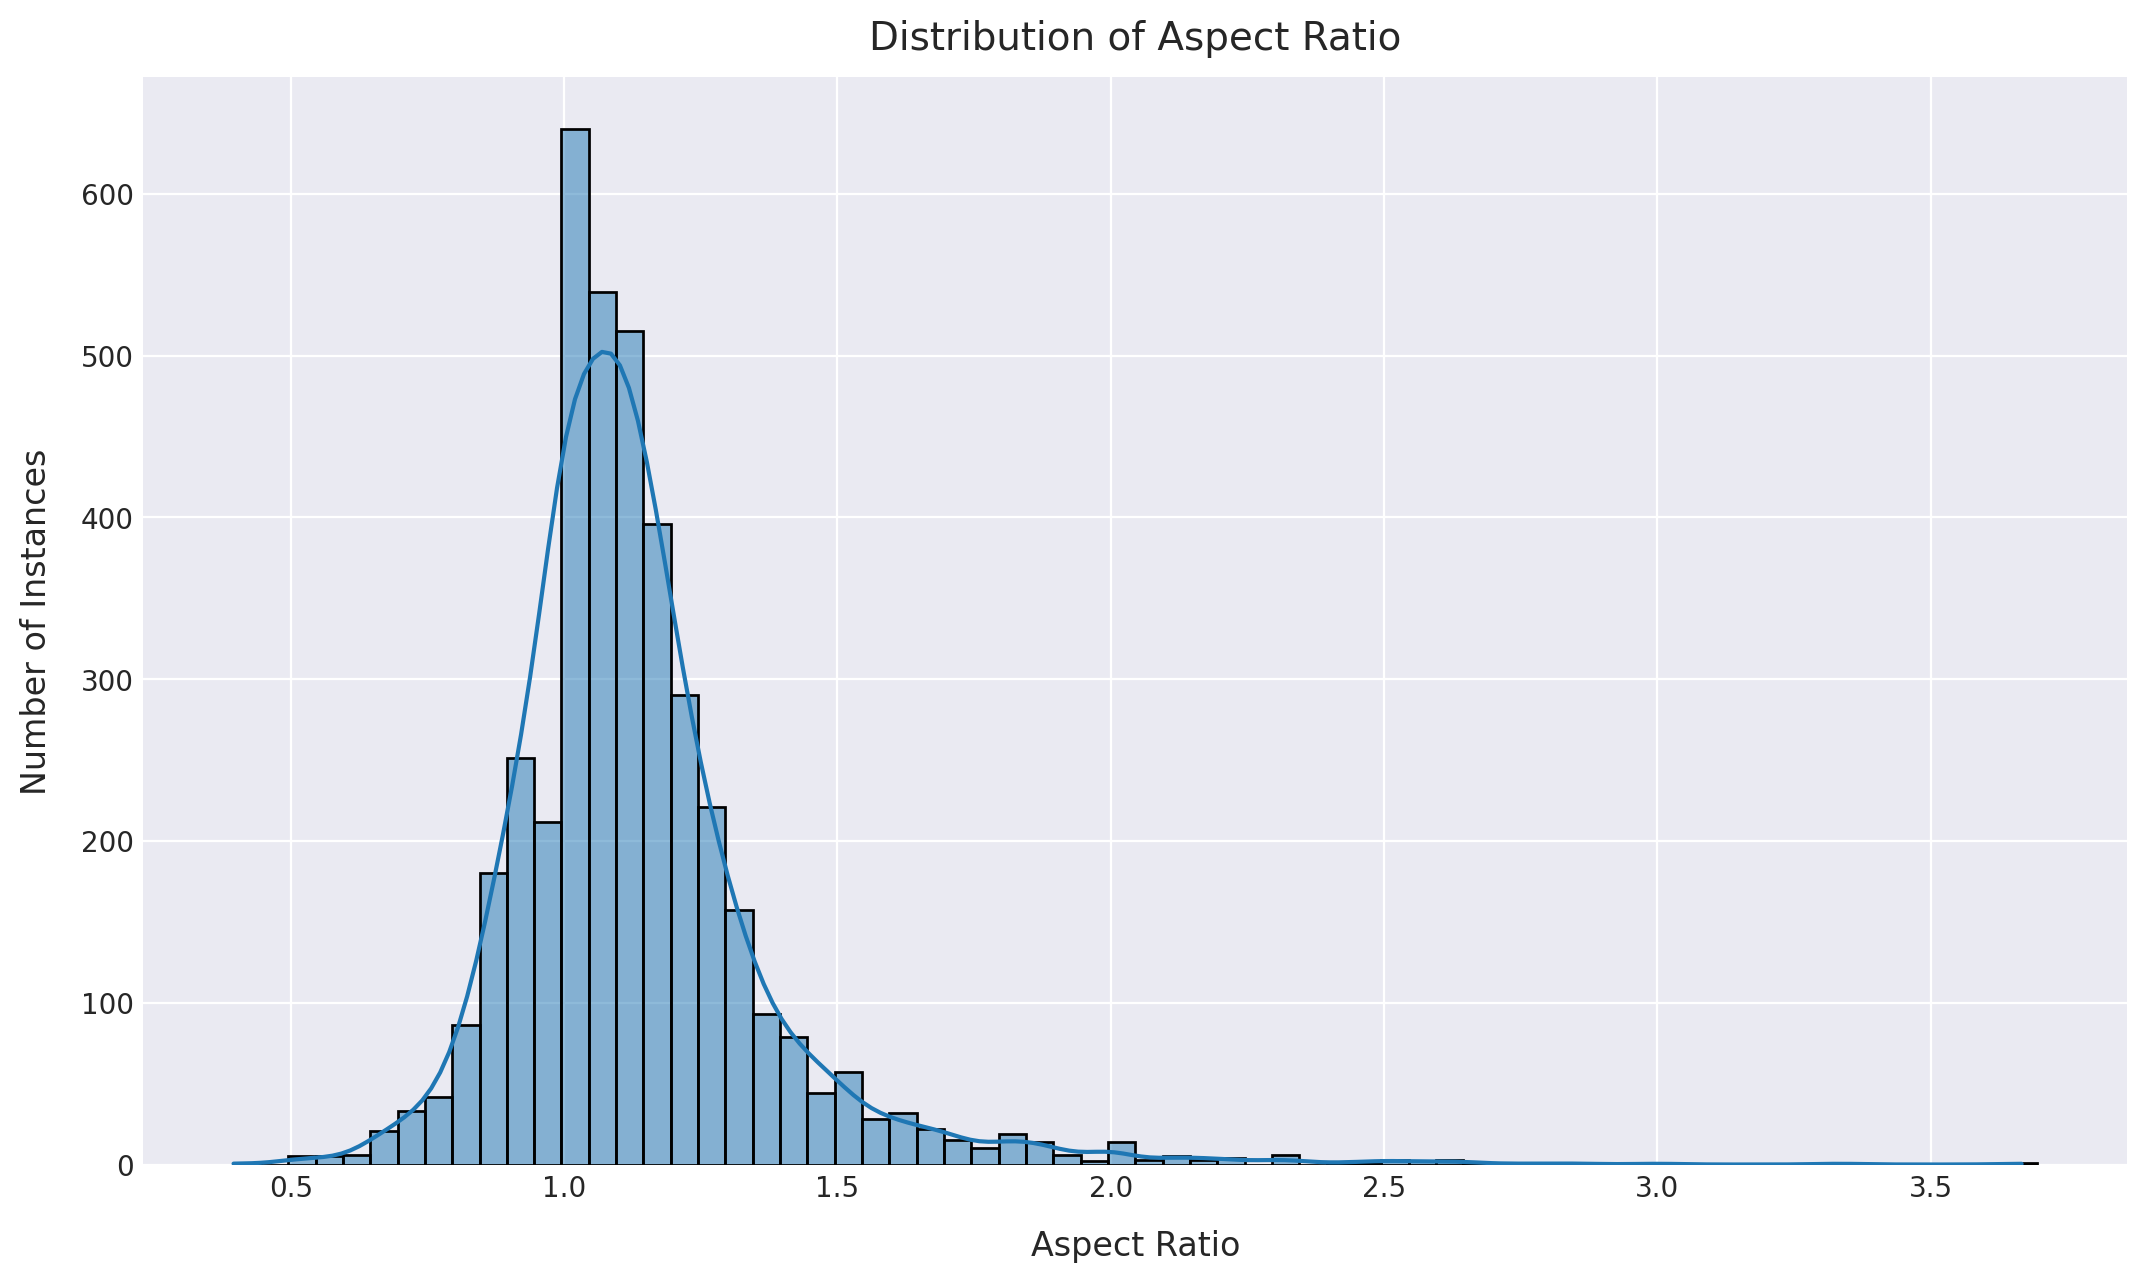

In [19]:
with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(1,1, figsize=(12.8,7.2), dpi=200)
    sns.histplot(data=data, x='cropped_aspect_ratio', kde=True, ax=ax, binwidth=0.05)
    ax.set_title("Distribution of Aspect Ratio", fontsize=14, pad=10);
    ax.set_xlabel("Aspect Ratio", fontsize=12, labelpad=10);
    ax.set_ylabel("Number of Instances", fontsize=12, labelpad=10);

### 7. Distribution of Aspect Ratio of the Cropped Images for Each Class

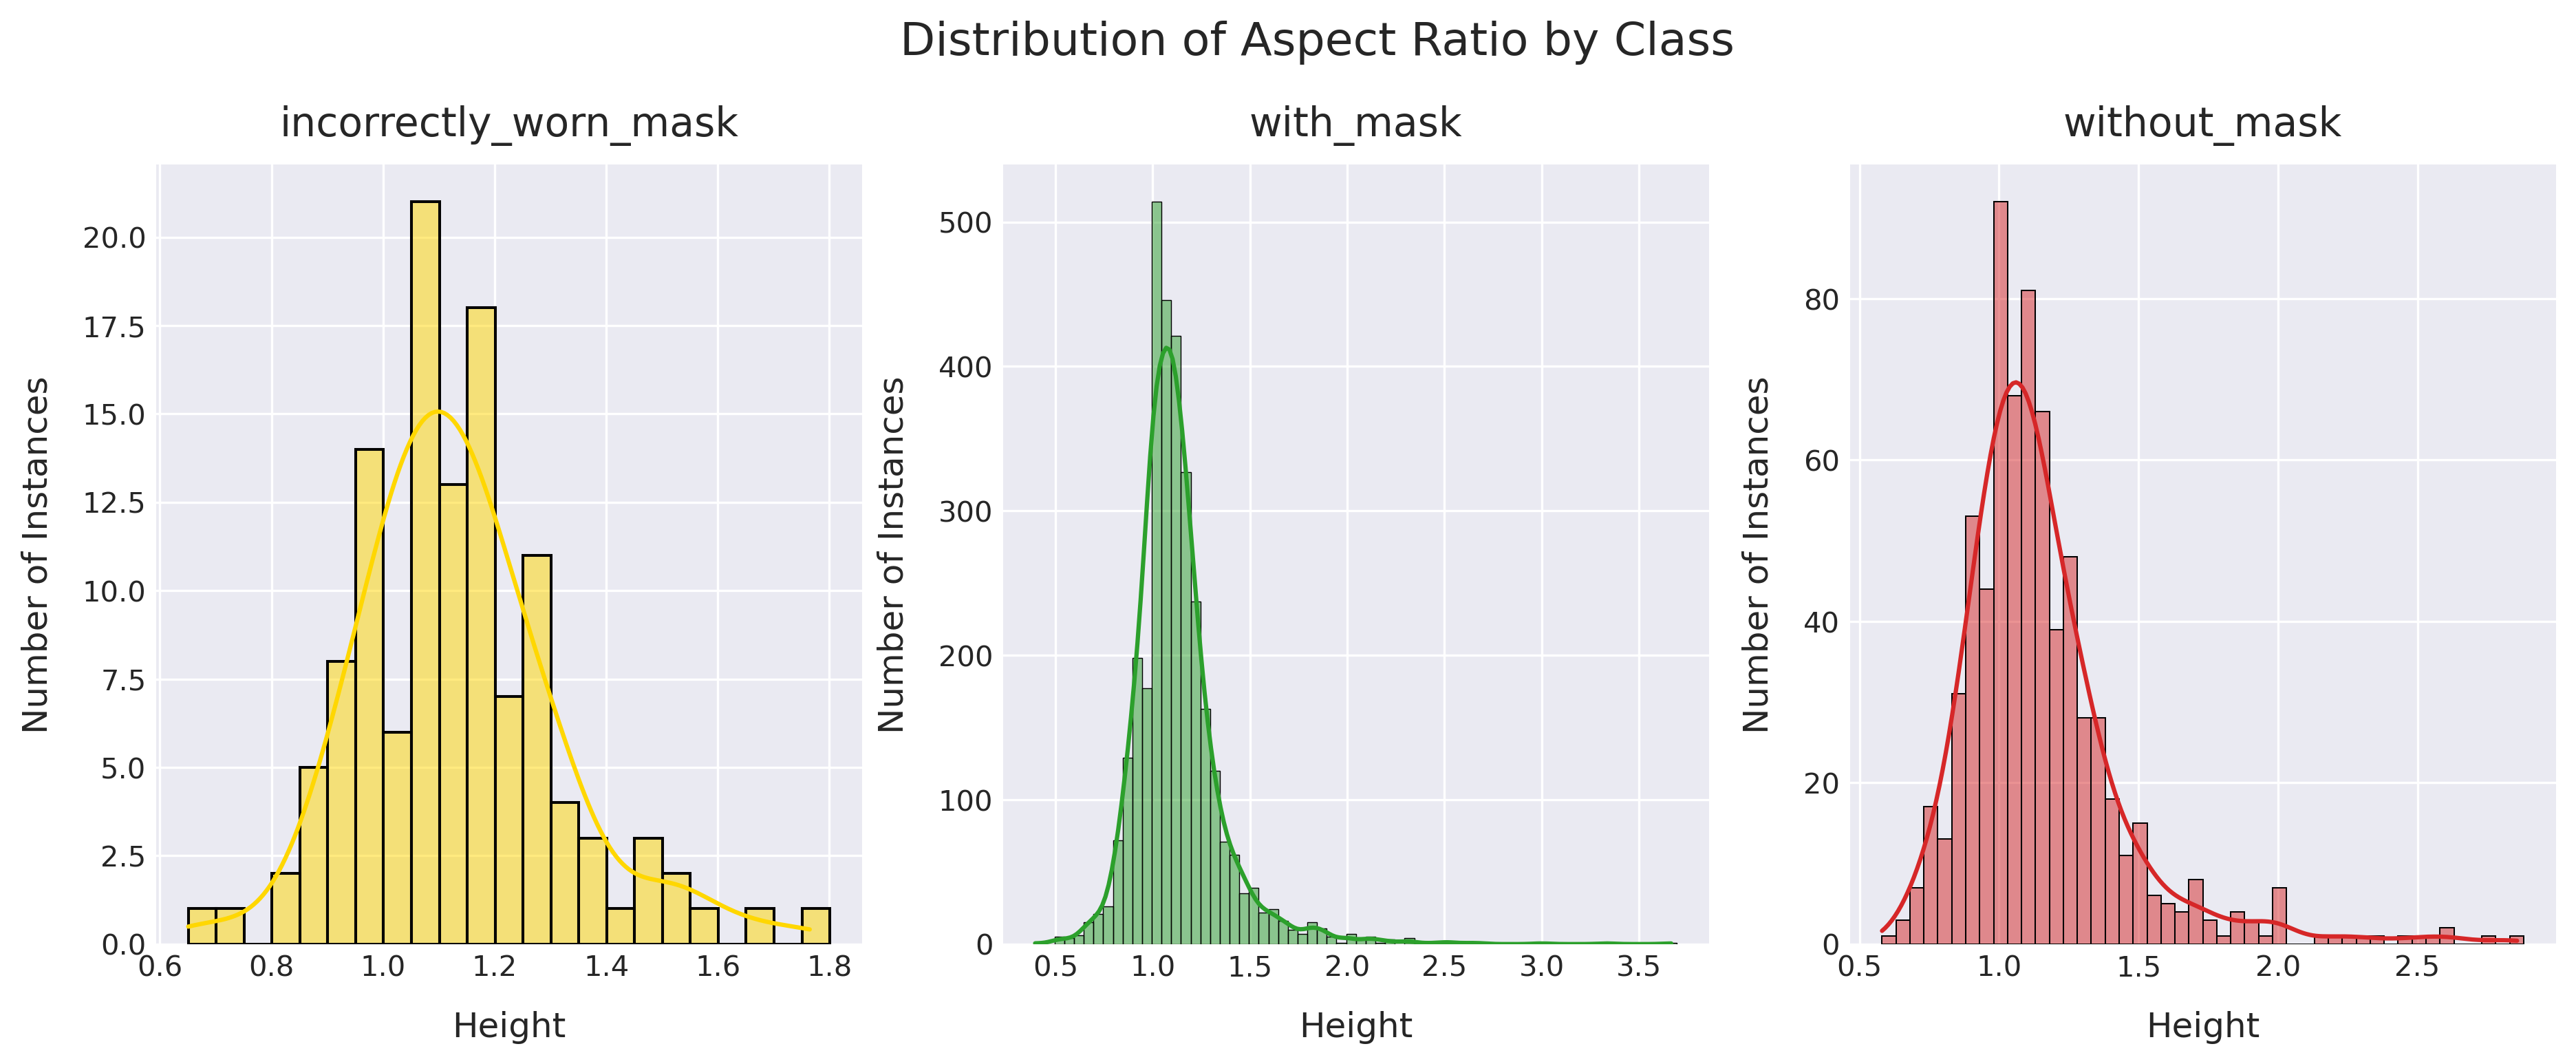

In [20]:
with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(1,3, figsize=(15,5), dpi=300, sharey=False)
    
    for i in range(len(classes)):
        sns.histplot(data.loc[data.name==classes[i]], x='cropped_aspect_ratio', kde=True, ax=ax[i], color=cols[i], binwidth=0.05)
        ax[i].set_xlabel("Height", fontsize=12, labelpad=10);
        ax[i].set_ylabel("Number of Instances", fontsize=12, labelpad=10);
        ax[i].set_title(classes[i], fontsize=14, pad=10);
        
    fig.suptitle('Distribution of Aspect Ratio by Class', y=1.02, fontsize=16)

## Train - Validation - Test Split

* The training set contains 70% of the data
* The validation set contains 15% of the data
* The testing set contains 15% of the data

Seed can be set for reproducibility

In [21]:
test_rate = 0.15
test_idx = int(test_rate * len(X))
val_idx = 2 * int(test_rate * len(X))

seed = 50
indices = np.arange(len(X))
np.random.seed(seed)
np.random.shuffle(indices)

# Training Sample
X_train = [X[i] for i in indices[:-val_idx]]
Y_train = [Y[i] for i in indices[:-val_idx]]

# Validation Sample
X_val = [X[i] for i in indices[-val_idx:-test_idx]]
Y_val = [Y[i] for i in indices[-val_idx:-test_idx]]

# Testing Sample
X_test = [X[i] for i in indices[-test_idx:]]
Y_test = [Y[i] for i in indices[-test_idx:]]

## Custom Image Generator

A custom generator is created that can be used for the three preprocessing techniques used:

1. **Blind Resizing**
    * All the cropped images are resized to a common size using TensorFlow's `resize_with_pad()` function
    * The common size chosen is `(28,28)` which is slightly larger than the median size of all the images
    * Custom sizes can also be specified by the user by changing the value of the variable `resize_shape` in the section **Model 1**


2. **Data Augmented Input**
    * Since the number of training images is quite low, augmentation can be used to increase the diversity of the training set by applying random transformations
    * This can also prevent the model from learning irrelevant features in the data set
    * The images are also resized to `(28,28)`
 
 
3. **Fully Convolutional Network**
    * This is similar to the first technique, except that the size of each batch is different
    * Convolutional Neural Networks require fixed input dimensions
    * To develop a model that can handle variable input dimensions, fully convolutional networks (FCNs) were used
    * FCNs do not contain any Dense layers. Instead, they have 1x1 convolutions that perform the same function as Dense layers
    * The median sizes of each batch was used as the batch size. This value is different for each batch

### Functions in the Custom Generator

1. `resize_images(images, output_shape)`
    * This function accepts an array of images and an output size and reshapes each image to the output size


2. `image_group_generator()`
    * This function shuffles the images if a flag is True
    * It creates two lists - the first with groups of images and the second with the corresponding labels


3. `image_batch_generator(image_group)`
    * This function decides the shape the images are to be resized based on the model being used
    * It also performs the necessary preprocessing (if any - data augmentation) on the images
    * It accepts an image group created by the previous function and returns an image batch after resizing and preprocessing

In [22]:
class CustomGenerator(tf.keras.utils.Sequence): 
    
    def __init__(self, X, Y, batch_size, model_num, shuffle_flag=True, res_shape=None):
        
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.shuffle_flag = shuffle_flag
        self.image_group_generator()
        self.model_num = model_num
        self.res_shape = res_shape
        self.augmentor = ImageDataGenerator(rotation_range=10, 
                                            width_shift_range=0.01, 
                                            height_shift_range=0.01, 
                                            horizontal_flip=True)
        
    def resize_images(self, images, output_shape):
        resized_images = list()
        
        for img in images:
            resized_images.append(tf.image.resize_with_pad(tf.image.convert_image_dtype(img, 
                                                                                        tf.float32), 
                                                           output_shape[0], 
                                                           output_shape[1]))
            
        return np.array(resized_images)
    
    def image_group_generator(self):
        
        indices = np.arange(len(self.X))
        
        # Shuffle the images and labels if flag is True
        if self.shuffle_flag:
            seed = 2248
            np.random.seed(seed)
            np.random.shuffle(indices)
        
        # Create groups of batch_size
        indices = [[indices[i % len(self.X)] for i in range(j, j + self.batch_size)] for j in range(0, len(self.X), self.batch_size)]
        
        self.image_groups = [[self.X[i] for i in j] for j in indices]
        self.label_groups = [[self.Y[i] for i in j] for j in indices]
    
    def image_batch_generator(self, image_group):
        
        if self.model_num == 1 or self.model_num == 2:
            batch_shape = self.res_shape
        elif self.model_num == 3:
            batch_shape = tuple(np.median(np.array([a.shape for a in x]), axis=0)[:2].astype(int))
        
        image_batch = self.resize_images(image_group, batch_shape)
        
        if self.model_num == 2:
            img_gen = self.augmentor.flow(x=image_batch, batch_size = self.batch_size, shuffle=False)
            image_batch = img_gen.next()
        
        return image_batch
    
    def __len__(self):
        return len(self.image_groups)
    
    def __getitem__(self, index):
        image_group = self.image_groups[index]
        image_batch = self.image_batch_generator(image_group)
        label_batch = np.array(self.label_groups[index])
        
        return image_batch, label_batch
    

## Validation Metrics

### 1. Accuracy and Loss Plots

This function displays the accuracy and loss plots after every epoch. It requires model history as input.

In [23]:
def validation_plots(history):
    
    fig, ax = plt.subplots(1,2, figsize=(12.8,4.8), dpi=200)
    
    ax[0].plot(np.array(history.history['accuracy'])*100, label='Training Accuracy')
    ax[0].plot(np.array(history.history['val_accuracy'])*100, label='Validation Accuracy')
    ax[0].set_ylabel("Accuracy", fontsize=12, labelpad=10)
    ax[0].set_title("Accuracy", fontsize=14, pad=10)
    
    ax[1].plot(history.history['loss'], label='Training Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_ylabel("Loss", fontsize=12, labelpad=10)
    ax[1].set_title("Loss", fontsize=14, pad=10) 
    
    for axis in ax:
        axis.set_xlabel("Epoch", fontsize=12, labelpad=10)
        axis.legend(loc='best')
        axis.grid(linestyle=":")

### 2. Confusion Matrix

This function displays the confusion matrix of the predicted and true labels. It requires true labels and predicted labels as input.

In [24]:
def confusion_matrix_plot(y_true, y_pred):
    
    conf_mat = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(1,1, figsize=(6.4,6.4), dpi=100)
    sns.heatmap(conf_mat, 
                ax=ax, 
                annot=True, 
                linecolor='white', 
                linewidth=1, 
                square=True, 
                fmt='d', 
                cmap='vlag_r')
    
    ax.set_xlabel("Predicted Label", fontsize=12, labelpad=15)
    ax.set_ylabel("True Label", fontsize=12, labelpad=15)
    ax.set_title("Confusion Matrix", fontsize=14, pad=15)
    ax.set_xticklabels(classes, rotation=0)
    ax.set_yticklabels(classes, rotation=0)

### 3. ROC Curve

This function displays the ROC curve for the three classes. It requires the true labels and predicted labhels as input.

In [25]:
def roc_plot(y_true, y_pred):

    y1 = one_hot_encode(y_true)
    y2 = one_hot_encode(y_pred)
    
    fig, ax = plt.subplots(1,1, figsize = (6.4, 4.8), dpi=100)
    
    for (i, class_name) in enumerate(classes):
        fpr, tpr, _ = roc_curve(y1[:,i], y2[:,i])
        
        ax.plot(fpr, tpr, label="{} - AUC = {:.2f}".format(class_name, auc(fpr, tpr)), color=cols[i])
        ax.plot(fpr, fpr, linestyle="--", color='blue')
        ax.set_xlabel('False Positive Rate', fontsize=12, labelpad=10)
        ax.set_ylabel('True Positive Rate', fontsize=12, labelpad=10)
        ax.set_title("ROC Curve", fontsize=14, pad=10)
        ax.legend(loc='best')
        ax.grid(linestyle=":", alpha=0.5)

### 4. Classification Report

This function displays the following validation metrics:
* Test accuracy
* Classification report with precision, recall, f1 score, and support of each class
* Macro average and weighted macro average
* choen's kappa score for multiclass predictions

In [26]:
def class_report(y_true, y_pred):
    
    print("Test Accuracy: {:.4f}%".format(100*np.mean(y_true==y_pred)))
    
    print("Classification Report:\n",
      classification_report(y_true, y_pred))
    
    print("Cohen's Kappa Score: {:.4f}".format(cohen_kappa_score(y_true, y_pred)))

## Model 1 - Blind Resizing

In [27]:
resize_shape = (28,28)

In [28]:
m1 = models.Sequential()

m1.add(layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', strides=(1,1), input_shape=resize_shape + (3,)))
m1.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
m1.add(layers.Dropout(rate=0.15))

m1.add(layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu', strides=(1,1)))
m1.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
m1.add(layers.Dropout(rate=0.15))

m1.add(layers.Conv2D(filters=128, kernel_size=5, padding='same', activation='relu', strides=(1,1)))
m1.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
m1.add(layers.Dropout(rate=0.25))

m1.add(layers.Flatten())

m1.add(layers.Dense(1024, activation='relu'))
m1.add(layers.Dropout(rate=0.4))

m1.add(layers.Dense(128, activation='relu'))
m1.add(layers.Dropout(rate=0.4))

m1.add(layers.Dense(32, activation='relu'))
m1.add(layers.Dropout(rate=0.25))

m1.add(layers.Dense(3, activation='softmax'))

In [29]:
batch_size = 250

train_generator_1 = CustomGenerator(X_train, 
                                    Y_train, 
                                    batch_size=batch_size, 
                                    model_num=1, 
                                    shuffle_flag=True, 
                                    res_shape=resize_shape)

val_generator_1 = CustomGenerator(X_val, 
                                  Y_val, 
                                  batch_size=batch_size, 
                                  model_num=1, 
                                  shuffle_flag=True, 
                                  res_shape=resize_shape)

pred_generator_1 = CustomGenerator(X_test, 
                                   Y_test, 
                                   batch_size=1, 
                                   model_num=1, 
                                   shuffle_flag=False, 
                                   res_shape=resize_shape)

In [30]:
m1.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
history_1 = m1.fit(train_generator_1, validation_data=val_generator_1, epochs=10)

Epoch 1/10
12/12 [==============================] - 17s 1s/step - loss: 0.6961 - accuracy: 0.7410 - val_loss: 0.5312 - val_accuracy: 0.8253
Epoch 2/10
12/12 [==============================] - 12s 968ms/step - loss: 0.5409 - accuracy: 0.7830 - val_loss: 0.4030 - val_accuracy: 0.8253
Epoch 3/10
12/12 [==============================] - 13s 1s/step - loss: 0.4537 - accuracy: 0.7827 - val_loss: 0.3302 - val_accuracy: 0.8253
Epoch 4/10
12/12 [==============================] - 13s 1s/step - loss: 0.3678 - accuracy: 0.8023 - val_loss: 0.2570 - val_accuracy: 0.9187
Epoch 5/10
12/12 [==============================] - 12s 1s/step - loss: 0.2978 - accuracy: 0.9003 - val_loss: 0.2549 - val_accuracy: 0.9107
Epoch 6/10
12/12 [==============================] - 12s 1s/step - loss: 0.2518 - accuracy: 0.9237 - val_loss: 0.2019 - val_accuracy: 0.9307
Epoch 7/10
12/12 [==============================] - 12s 1s/step - loss: 0.2257 - accuracy: 0.9310 - val_loss: 0.1863 - val_accuracy: 0.9333
Epoch 8/10
12/12 

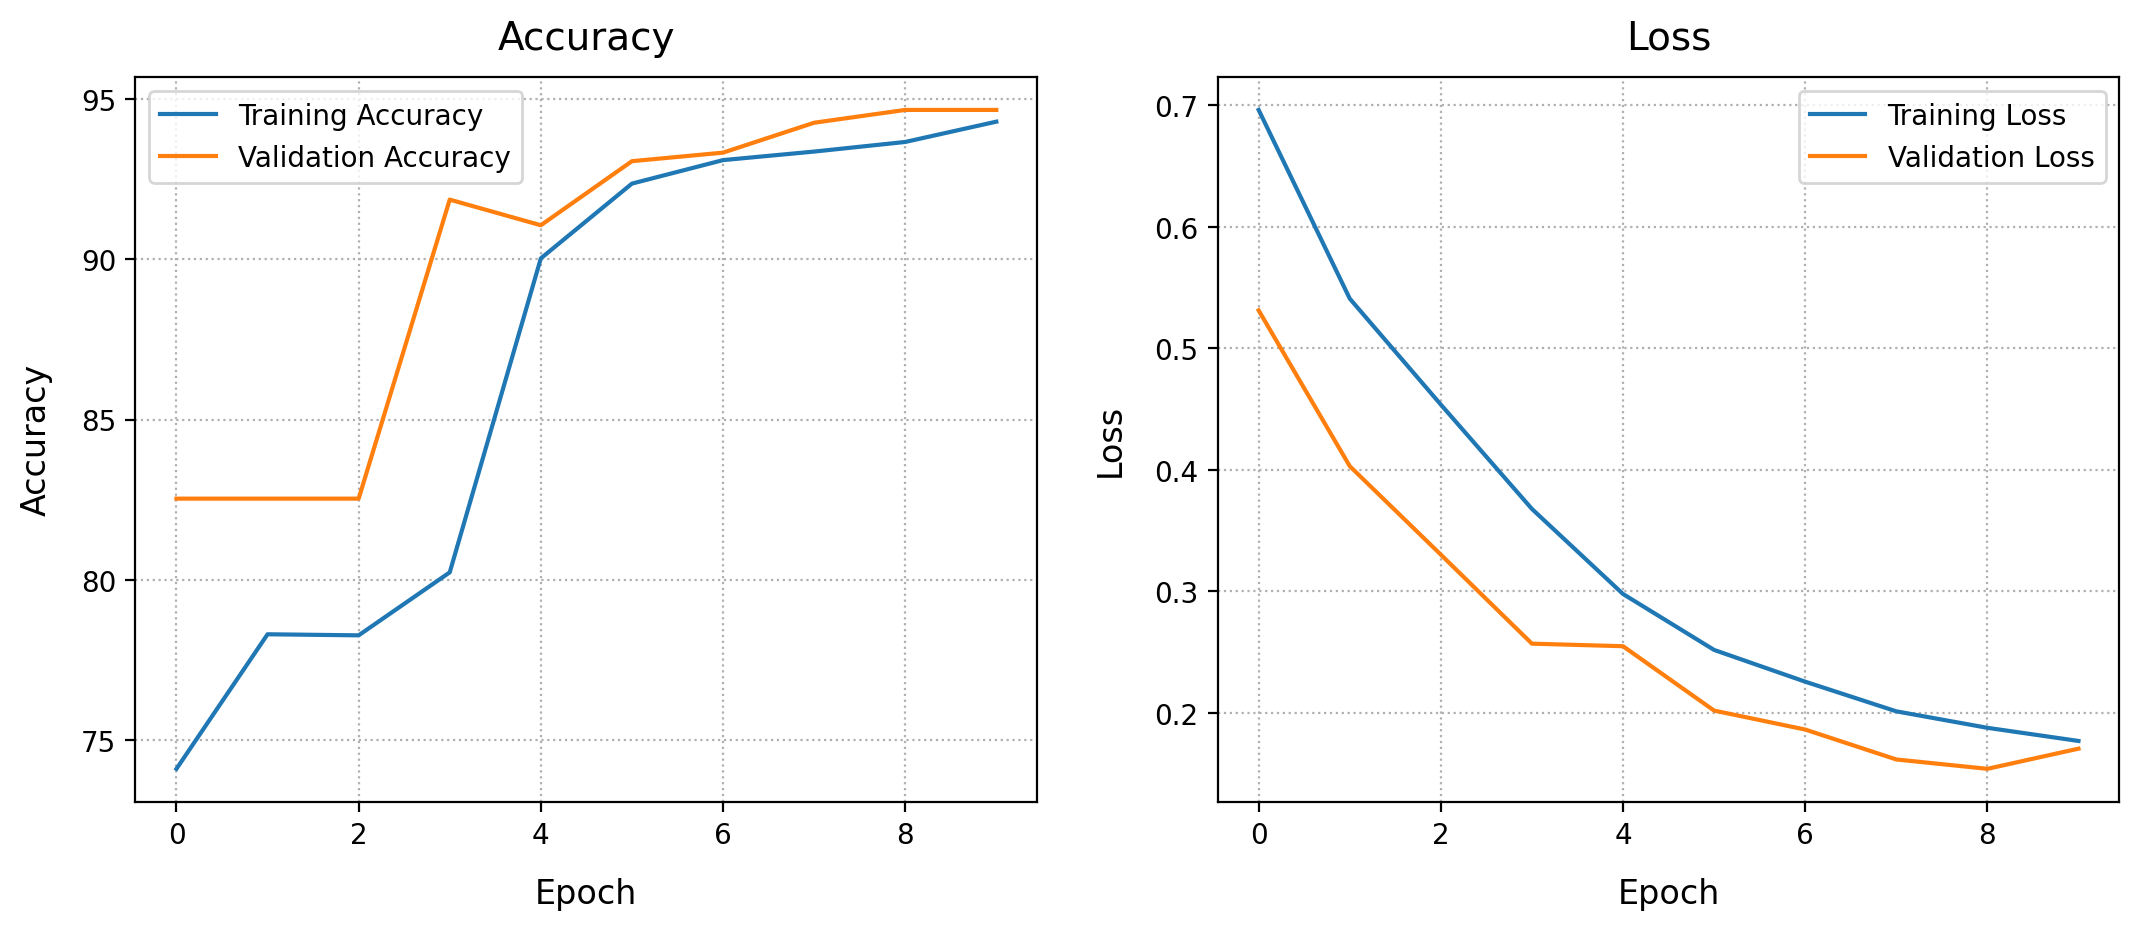

In [31]:
validation_plots(history_1)

In [32]:
y_pred = classes[np.argmax(m1.predict(pred_generator_1), axis=1)]
y_true = label_decoder(Y_test)

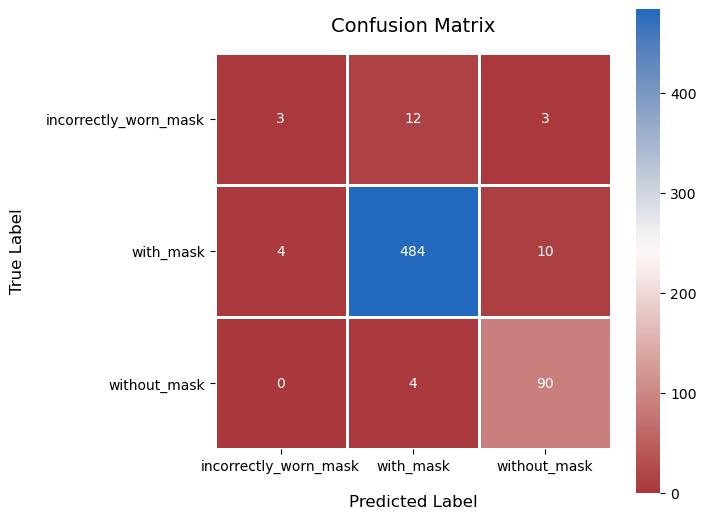

In [33]:
confusion_matrix_plot(y_true, y_pred)

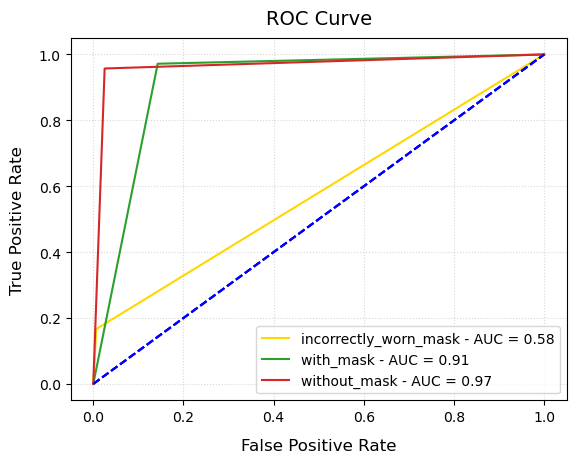

In [34]:
roc_plot(y_true, y_pred)

In [35]:
class_report(y_true, y_pred)

Test Accuracy: 94.5902%
Classification Report:
                        precision    recall  f1-score   support

incorrectly_worn_mask       0.43      0.17      0.24        18
            with_mask       0.97      0.97      0.97       498
         without_mask       0.87      0.96      0.91        94

             accuracy                           0.95       610
            macro avg       0.76      0.70      0.71       610
         weighted avg       0.94      0.95      0.94       610

Cohen's Kappa Score: 0.8223


## Model 2 - Data Augmented Input

In [36]:
resize_shape = (28,28)

In [37]:
m2 = models.Sequential()

m2.add(layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', strides=(1,1), input_shape=resize_shape + (3,)))
m2.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
m2.add(layers.Dropout(rate=0.15))

m2.add(layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu', strides=(1,1)))
m2.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
m2.add(layers.Dropout(rate=0.15))

m2.add(layers.Conv2D(filters=128, kernel_size=5, padding='same', activation='relu', strides=(1,1)))
m2.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
m2.add(layers.Dropout(rate=0.25))

m2.add(layers.Flatten())

m2.add(layers.Dense(1024, activation='relu'))
m2.add(layers.Dropout(rate=0.4))

m2.add(layers.Dense(128, activation='relu'))
m2.add(layers.Dropout(rate=0.4))

m2.add(layers.Dense(32, activation='relu'))
m2.add(layers.Dropout(rate=0.25))

m2.add(layers.Dense(3, activation='softmax'))

In [38]:
batch_size = 250
model_num = 2
train_generator_2 = CustomGenerator(X_train, 
                                    Y_train, 
                                    batch_size=batch_size, 
                                    model_num=model_num, 
                                    shuffle_flag=True, 
                                    res_shape=resize_shape)

val_generator_2 = CustomGenerator(X_val, 
                                  Y_val, 
                                  batch_size=batch_size, 
                                  model_num=model_num, 
                                  shuffle_flag=True, 
                                  res_shape=resize_shape)

In [39]:
m2.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
history_2 = m2.fit(train_generator_2, validation_data=val_generator_2, epochs=10)

Epoch 1/10
12/12 [==============================] - 13s 1s/step - loss: 0.7224 - accuracy: 0.7253 - val_loss: 0.6349 - val_accuracy: 0.8253
Epoch 2/10
12/12 [==============================] - 13s 1s/step - loss: 0.5452 - accuracy: 0.7820 - val_loss: 0.5586 - val_accuracy: 0.8253
Epoch 3/10
12/12 [==============================] - 13s 1s/step - loss: 0.4682 - accuracy: 0.7853 - val_loss: 0.3789 - val_accuracy: 0.8253
Epoch 4/10
12/12 [==============================] - 13s 1s/step - loss: 0.3595 - accuracy: 0.8490 - val_loss: 0.2853 - val_accuracy: 0.9000
Epoch 5/10
12/12 [==============================] - 14s 1s/step - loss: 0.2860 - accuracy: 0.9127 - val_loss: 0.2293 - val_accuracy: 0.9200
Epoch 6/10
12/12 [==============================] - 14s 1s/step - loss: 0.2445 - accuracy: 0.9270 - val_loss: 0.1992 - val_accuracy: 0.9347
Epoch 7/10
12/12 [==============================] - 14s 1s/step - loss: 0.2421 - accuracy: 0.9267 - val_loss: 0.1967 - val_accuracy: 0.9280
Epoch 8/10
12/12 [==

In [40]:
y_pred = classes[np.argmax(m2.predict(pred_generator_1), axis=1)]

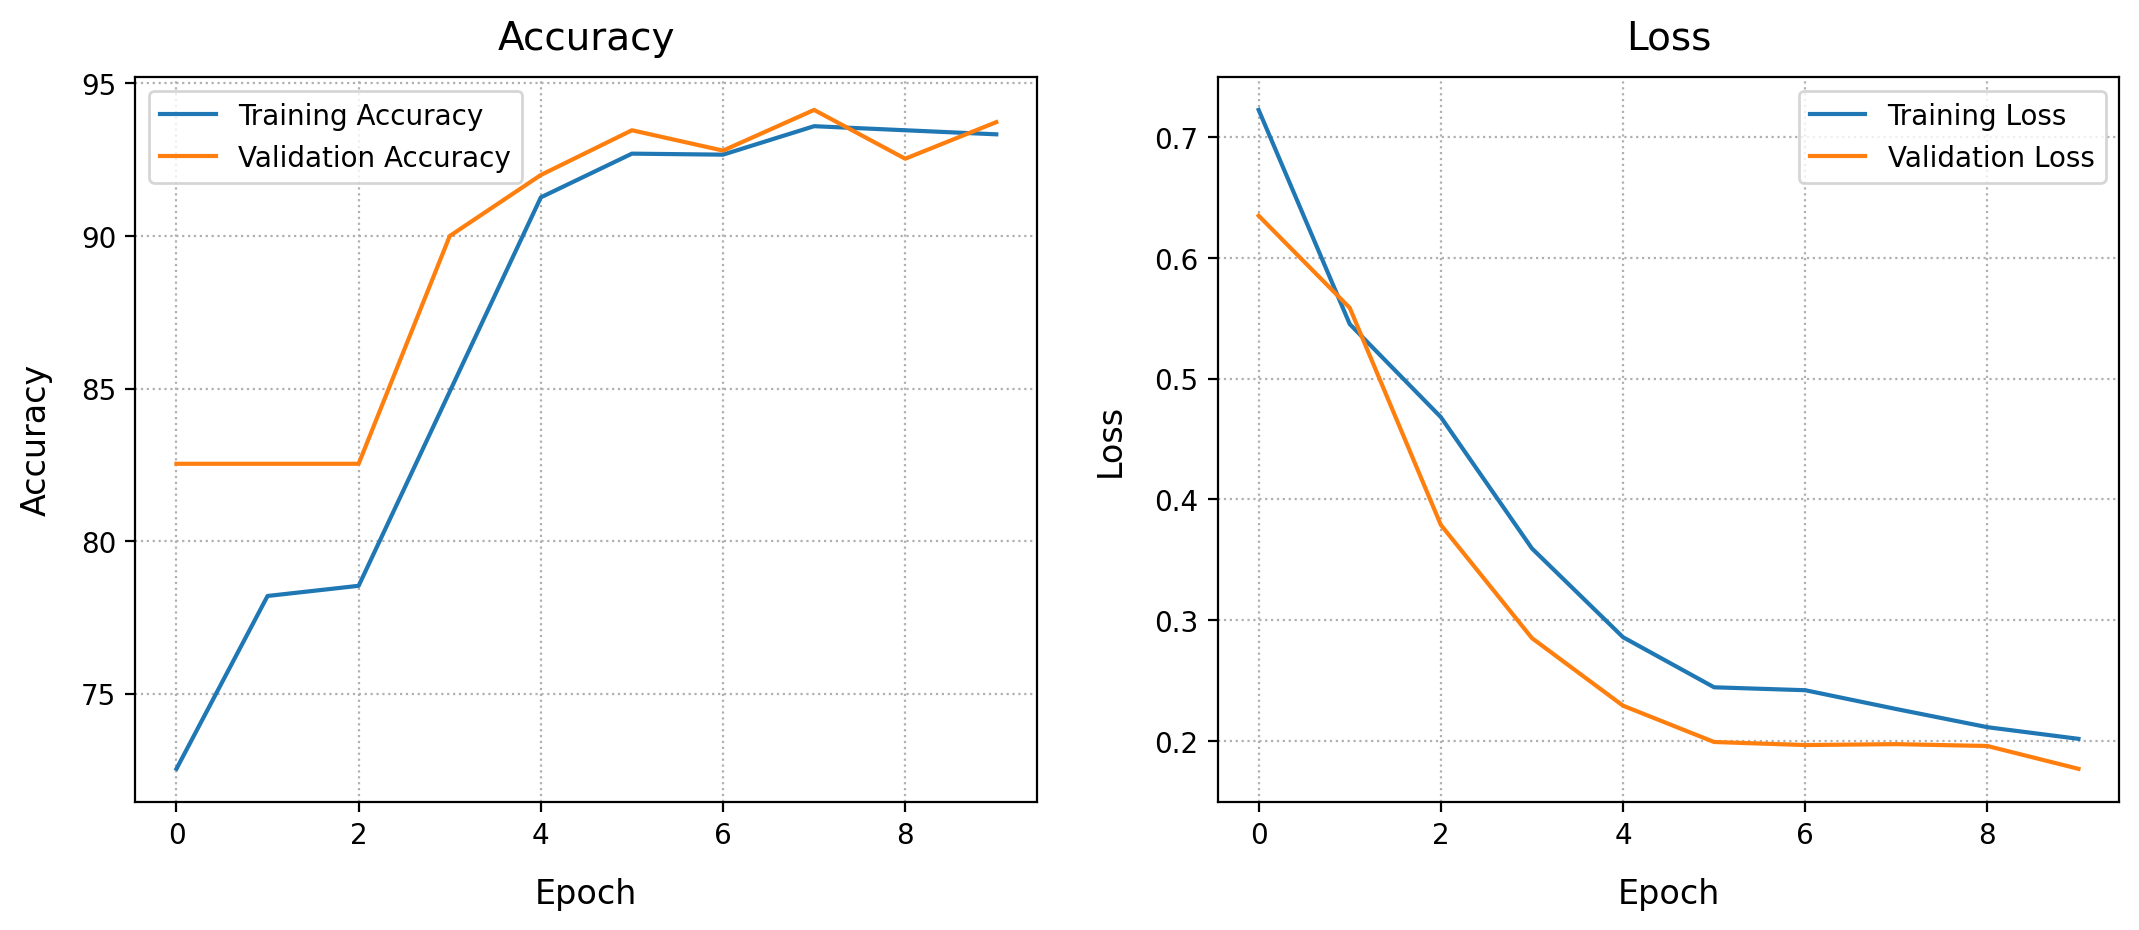

In [41]:
validation_plots(history_2)

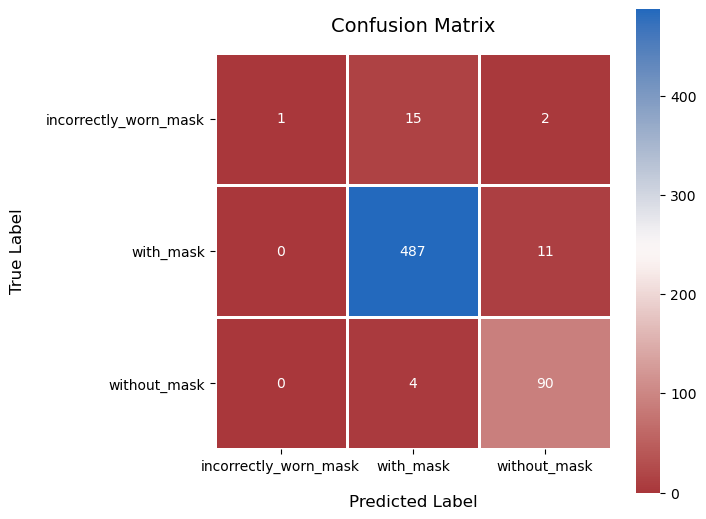

In [42]:
confusion_matrix_plot(y_true, y_pred)

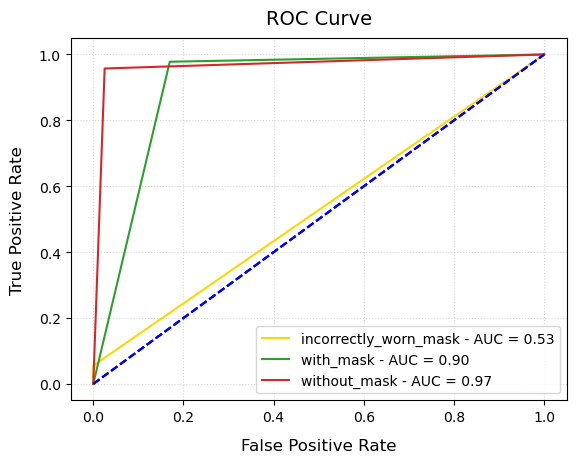

In [43]:
roc_plot(y_true, y_pred)

In [44]:
class_report(y_true, y_pred)

Test Accuracy: 94.7541%
Classification Report:
                        precision    recall  f1-score   support

incorrectly_worn_mask       1.00      0.06      0.11        18
            with_mask       0.96      0.98      0.97       498
         without_mask       0.87      0.96      0.91        94

             accuracy                           0.95       610
            macro avg       0.95      0.66      0.66       610
         weighted avg       0.95      0.95      0.94       610

Cohen's Kappa Score: 0.8232


## Model 3 - Batches of Different Size / Fully Convolutional Network

In [45]:
m3 = models.Sequential()

m3.add(layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', strides=(1,1), input_shape=(None,None,3)))
m3.add(layers.Dropout(rate=0.15))

m3.add(layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu', strides=(1,1)))
m3.add(layers.Dropout(rate=0.15))

m3.add(layers.Conv2D(filters=128, kernel_size=5, padding='same', activation='relu', strides=(1,1)))
m3.add(layers.Dropout(rate=0.25))

m3.add(layers.Conv2D(filters=1024, kernel_size=1, padding='same', activation='relu', strides=(1,1)))
m3.add(layers.Dropout(rate=0.4))

m3.add(layers.Conv2D(filters=128, kernel_size=1, padding='same', activation='relu', strides=(1,1)))
m3.add(layers.Dropout(rate=0.4))

m3.add(layers.Conv2D(filters=32, kernel_size=1, padding='same', activation='relu', strides=(1,1)))
m3.add(layers.Dropout(rate=0.25))

m3.add(layers.Conv2D(filters=3, kernel_size=1, padding='same', activation='relu', strides=(1,1)))

m3.add(layers.GlobalMaxPooling2D())
m3.add(layers.Activation('softmax'))

In [46]:
batch_size = 100
model_num = 3

train_generator_3 = CustomGenerator(X_train, 
                                    Y_train, 
                                    batch_size=batch_size, 
                                    model_num=model_num, 
                                    shuffle_flag=True, 
                                    res_shape=resize_shape)

val_generator_3 = CustomGenerator(X_val, 
                                  Y_val, 
                                  batch_size=batch_size, 
                                  model_num=model_num, 
                                  shuffle_flag=True, 
                                  res_shape=resize_shape)

pred_generator_3 = CustomGenerator(X_test, 
                                   Y_test, 
                                   batch_size=1, 
                                   model_num=model_num, 
                                   shuffle_flag=False, 
                                   res_shape=resize_shape)

In [47]:
m3.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
history_3 = m3.fit(train_generator_3, validation_data=val_generator_3, epochs=10)

Epoch 1/10
29/29 [==============================] - 15s 454ms/step - loss: 0.7767 - accuracy: 0.7569 - val_loss: 0.6406 - val_accuracy: 0.8214
Epoch 2/10
29/29 [==============================] - 13s 443ms/step - loss: 0.6035 - accuracy: 0.7834 - val_loss: 0.5384 - val_accuracy: 0.8214
Epoch 3/10
29/29 [==============================] - 13s 448ms/step - loss: 0.5399 - accuracy: 0.7838 - val_loss: 0.4616 - val_accuracy: 0.8214
Epoch 4/10
29/29 [==============================] - 13s 444ms/step - loss: 0.4918 - accuracy: 0.7841 - val_loss: 0.3978 - val_accuracy: 0.8214
Epoch 5/10
29/29 [==============================] - 14s 471ms/step - loss: 0.4399 - accuracy: 0.8428 - val_loss: 0.3559 - val_accuracy: 0.8757
Epoch 6/10
29/29 [==============================] - 13s 450ms/step - loss: 0.4014 - accuracy: 0.8710 - val_loss: 0.3536 - val_accuracy: 0.8643
Epoch 7/10
29/29 [==============================] - 13s 448ms/step - loss: 0.4012 - accuracy: 0.8728 - val_loss: 0.3387 - val_accuracy: 0.9043

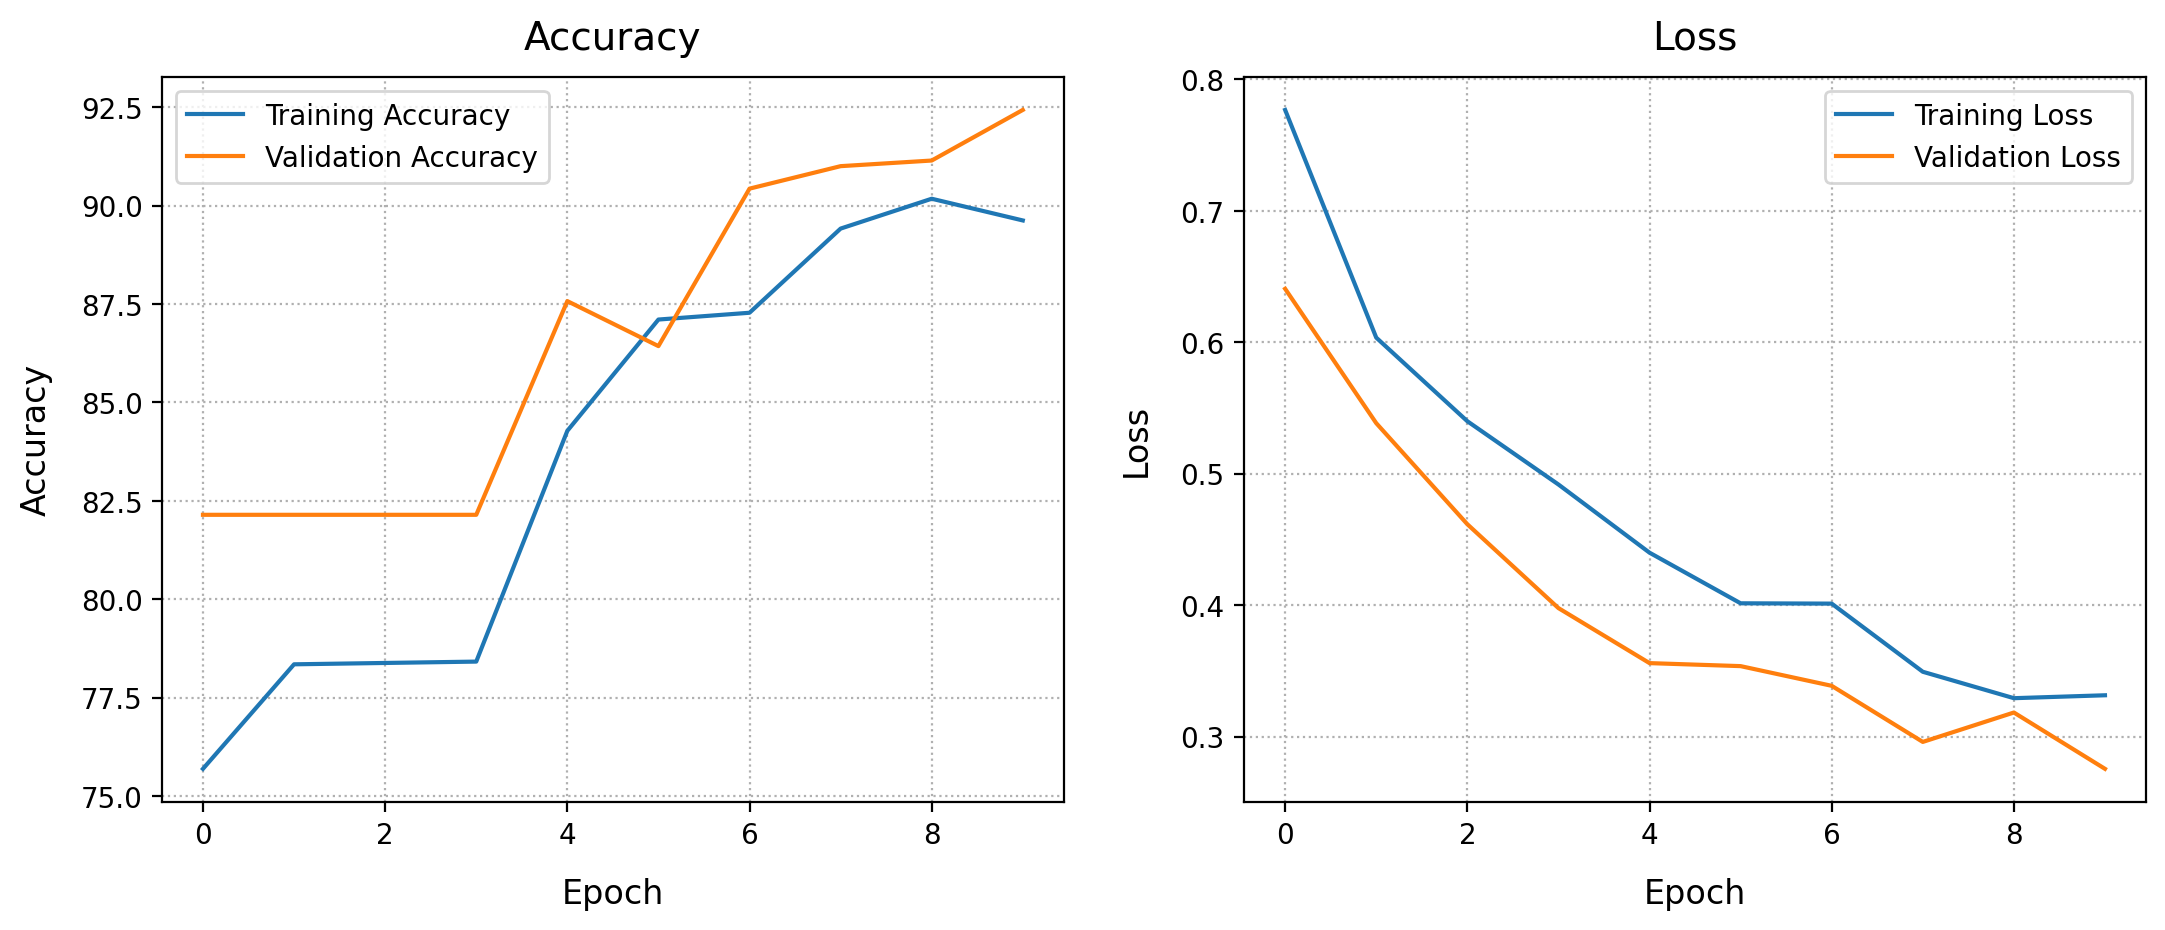

In [48]:
validation_plots(history_3)

In [49]:
y_pred = classes[np.argmax(m3.predict(pred_generator_3), axis=1)]

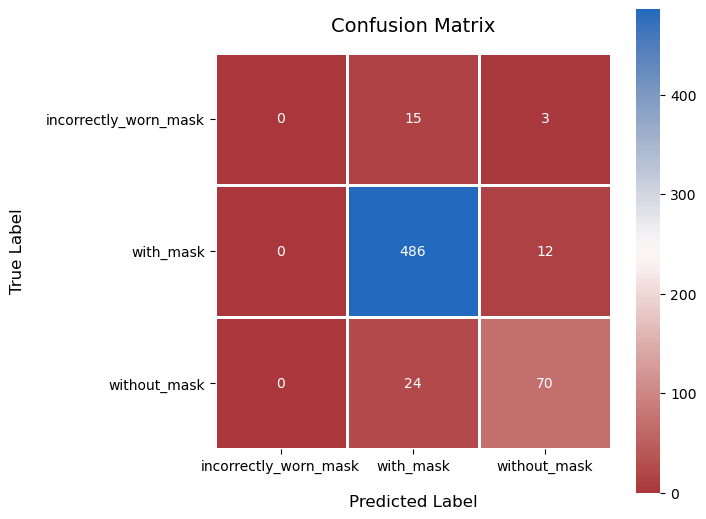

In [50]:
confusion_matrix_plot(y_true, y_pred)

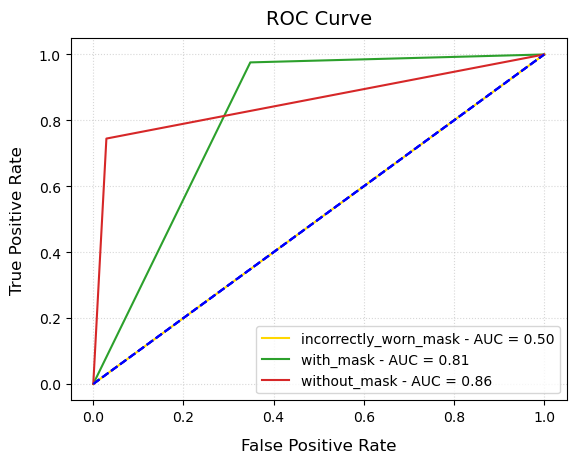

In [51]:
roc_plot(y_true, y_pred)

In [52]:
class_report(y_true, y_pred)

Test Accuracy: 91.1475%
Classification Report:
                        precision    recall  f1-score   support

incorrectly_worn_mask       0.00      0.00      0.00        18
            with_mask       0.93      0.98      0.95       498
         without_mask       0.82      0.74      0.78        94

             accuracy                           0.91       610
            macro avg       0.58      0.57      0.58       610
         weighted avg       0.88      0.91      0.90       610

Cohen's Kappa Score: 0.6791


## Predict Labels for all Faces in an Image

This function returns the predicted labels for every present in a souce image file.

It requires the following as input:
* `file_name` - File name of the source image (can be obtained from the images folder or by using `data.filename.unique()`
* `mdl` - The model to be used for prediction (m1, m2 or m3)
* `mdl_num` - Model number of the model to be used for prediction (1 if m1, 2 if m2, 3 if m3)

In [53]:
def predict_from_image_name(file_name, mdl, mdl_num):
    
    df = data.loc[data.filename==file_name]
    
    fnames = df.cropped_image_name.values
    
    x = []
    for fname in fnames:
        x.append(cv2.cvtColor(cv2.imread(path_cropped + "/" + fname), cv2.COLOR_BGR2RGB))
    
    y_true = df.name.values
    y = one_hot_encode(y_true)
    
    pred_gen = CustomGenerator(x, 
                               y, 
                               batch_size=1, 
                               model_num=mdl_num, 
                               shuffle_flag=False, 
                               res_shape=(28,28))
    
    y_pred = classes[np.argmax(mdl.predict(pred_gen), axis=1)]
    
    img_path = data.loc[data.filename==file_name].image_name.values[0]
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    for i in range(len(df)):
        
        x1 = df.iloc[i].xmin
        y1 = df.iloc[i].ymin
        x2 = df.iloc[i].xmax
        y2 = df.iloc[i].ymax
        
        if y_pred[i] == 'without_mask':
            col = "red"
        elif y_pred[i] == 'with_mask':
            col = "limegreen"
        elif y_pred[i] == "incorrectly_worn_mask":
            col = "gold"
        
        col = tuple(255*np.array(colors.to_rgb(col)))
        
        if y_pred[i] == 'without_mask':
            label = "No Mask"
        elif y_pred[i] == 'with_mask':
            label = "Mask"
        elif y_pred[i] == "incorrectly_worn_mask":
            label = "Wrong Mask"
        
        img = cv2.rectangle(img, (x1,y1), (x2,y2), col, 2)
        img = cv2.putText(img, label, (x1,y1-10), cv2.FONT_HERSHEY_DUPLEX, 0.5, col, 1)
    
    plt.figure(figsize=(12.8,7.2), dpi=100)
    plt.imshow(img);

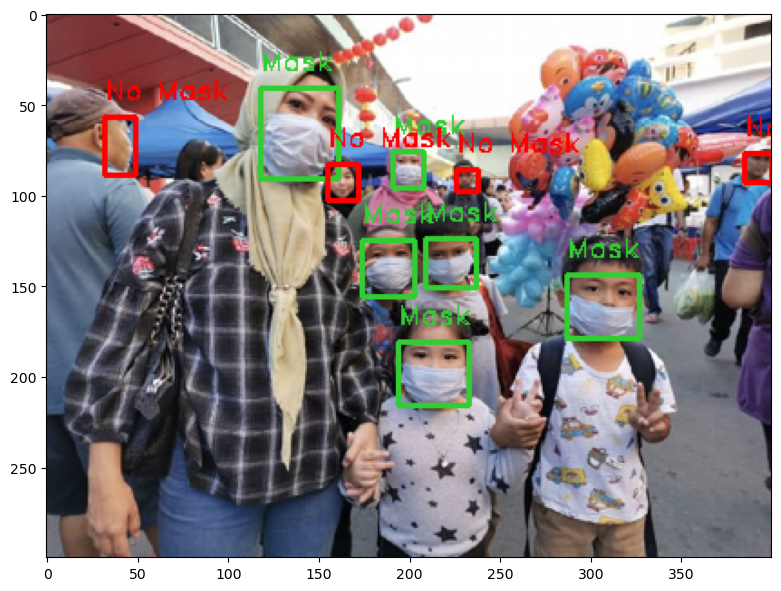

In [54]:
predict_from_image_name("maksssksksss253", m1, 1)